# MIE 1517 Final Project : State Farm Distracted Driver Detection

Group 4 :

Colab Link: https://drive.google.com/file/d/1AEghWltd99bP0-6mpgY3RvxGMYeV0J59/view?usp=sharing

# Motivation

The latest data available from the National Highway Transportation and Safety Administration (NHTSA) shows over 3,000 people were killed by distracted driving in 2020. This accounts for 64% of all accidents, more than drink driving and speeding.

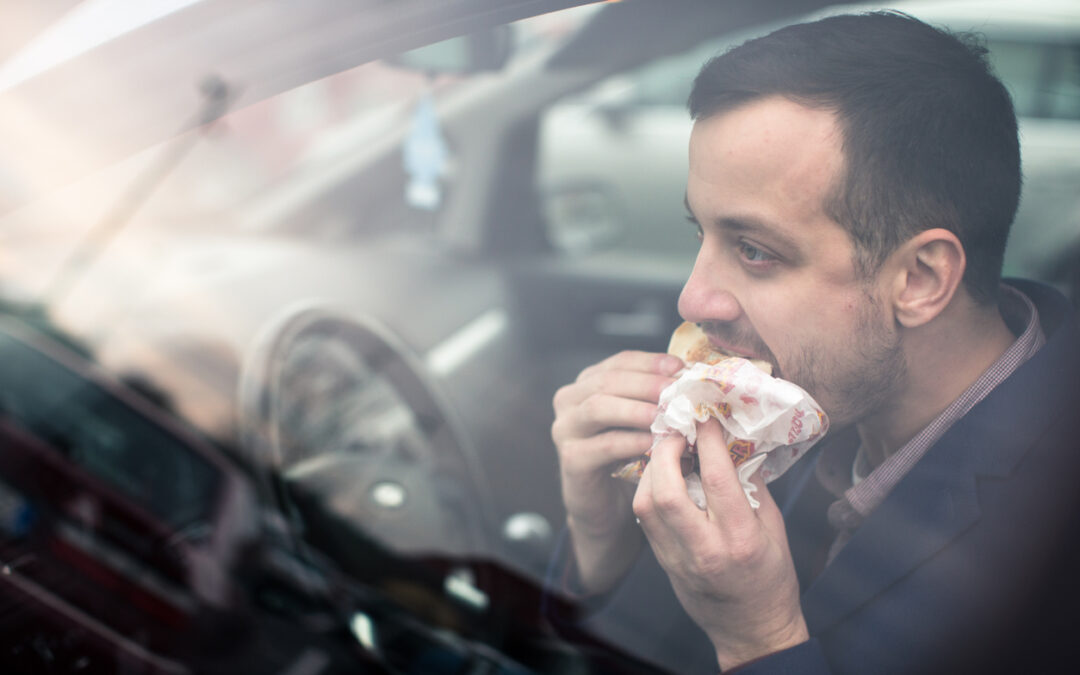

There are some crucial Distracted Driving statistics for Canada:
- 21% of all fatal car accidents are caused by using a phone or another electronic device.
- 27% of all serious car accident injuries are the direct consequence of actions like texting and driving or adjusting navigation.
- Young people aged 16 to 24 are the most likely to use electronic devices while driving.
- 47% of all Canadian drivers sometimes use smartphones in traffic.
- Distracted drivers are 3.6 times more likely to be involved in a traffic accident.
- 33% of Canadians use their phone while waiting for the green light.

Just think about how many accidents and injuries could be avoided in the future if we can deploy a model that can tell whether they are distracted or not and remind them if needed?

Thus, we want to build a model that can tell whether a driver is distracted or not while he/she is driving. <br>We believe this would reduce the number of car accidents greatly.

There are 10 different classes for our dataset.


They are:
- c0: safe driving
- c1: texting - right
- c2: talking on the phone - right
- c3: texting - left
- c4: talking on the phone - left
- c5: operating the radio
- c6: drinking
- c7: reaching behind
- c8: hair and makeup
- c9: talking to passenger

There are 22424 image samples in our dataset. We split them into approximately 80%, 12% and 8% for training, validation and test set. We cannot do a exact split since we split by drivers not images to prevent data leakage issue.

In this project, we aim to explore different data augmentation combinations in order to improve the accuracy of our model's predictions on unseen data. We are also going to explore the ways to reduce the degree of overfitting as we progress.

Please be aware that in this project, we have very limited cuda/gpu memory, we cannot even run our model using batch size > 32. This will cause cuda out of memory issue. So our experiments are only conducted using a batch size of 16 or 32. We also intended to try a ensemble model/voting classifier at the end but we encounter the same issue of cuda out of memory. Thus, our best model is a single transfer learning model selected based on the performance on the test data and new data we obtained.

# Imports

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import copy
import os
import shutil
from distutils.dir_util import copy_tree
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
torch.manual_seed(42)

In [ ]:
# Display GPU specs
from IPython.display import HTML
from subprocess import getoutput
s = getoutput('nvidia-smi')
if 'K80' in s:
  gpu = 'K80'
elif 'T4' in s:
  gpu = 'T4'
elif 'P100' in s:
  gpu = 'P100'
display(HTML(f"<h2>{gpu}</h2>"))
print(s)
!nvidia-smi -L

Fri Dec  2 21:38:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

We had hosted the data on our Google Drive accounts and mount the drive into the colab session. The project data was stored inside the directory: ```MIE1517/1517project/data```

The data was procured from: https://www.kaggle.com/competitions/state-farm-distracted-driver-detection/data

Steps to create the dataset:

1.   Download the train directory as a .zip file and place it inside the drive directory
2.   Download the .csv file and place it inside the drive directory

As Google accounts have only 15 GB of space by default, we are not able to provide a permanently hosted source of this data.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Extract and split the data

Data splitting in this problem is not trivial, like the one we did in the hand gesture classification. If handled improperly, it may leads to data leakage issue, which gives us over-optimistic test results. Specifically, we want our validation set and test set to closely resemble the reality that contains the drivers that are never seen in the training set during the training process.

After observing that there are 26 drivers in the dataset, and each driver has a relatively equal amount of images, we decided to put the first 20 drivers' images in the training set, 3 in the validation set, and the last 3 in the test set. We did this by for looping over all the images, mapping the driver id to each image (thanks to the csv table provided by Kaggle), and moving images to the different folders according to the driver id.

In [ ]:
# unzip zip files (in drive) to '/content'
# !unzip '/content/drive/MyDrive/MIE1517_DL/Distracted_Drivers/train.zip' -d '/content'
# !unzip '/content/gdrive/MyDrive/MIE1517/1517project/data/train.zip' -d '/content'

In [ ]:
from zipfile import ZipFile
with ZipFile('/content/gdrive/MyDrive/MIE1517/1517project/data/train.zip','r') as obj:
  obj.extractall('')

In [ ]:
root_dir = "/content/train"
classes = os.listdir(root_dir)
# there are 10 classes in total
classes

['c0', 'c7', 'c4', 'c8', 'c9', 'c1', 'c3', 'c5', 'c6', 'c2']

In [ ]:
# 1 to 1 mapping from image names to driver_id
driver_info = pd.read_csv('/content/gdrive/MyDrive/MIE1517/1517project/data/driver_imgs_list.csv')
driver_info.head()

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

In [ ]:
# there are 26 drivers in total
driver_info.subject.unique()

array(['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024',
       'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049',
       'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072',
       'p075', 'p081'], dtype=object)

In [ ]:
# first 20 drivers in the training set
# middle 3 drivers in the validation set
# last 3 drivers   in the test set
train_list = ['p002', 'p012', 'p014', 'p015', 'p016',
              'p021', 'p022', 'p024', 'p026', 'p035',
              'p039', 'p041', 'p042', 'p045', 'p047',
              'p049', 'p050', 'p051', 'p052', 'p056']
valid_list = ['p061', 'p064', 'p066']
test_list  = ['p072', 'p075', 'p081']

In [ ]:
# create directories
for i in range(0, len(classes)):
  os.makedirs(os.path.join(root_dir, "training_set"   , classes[i]))
  os.makedirs(os.path.join(root_dir, "validation_set" , classes[i]))
  os.makedirs(os.path.join(root_dir, "test_set"       , classes[i]))

In [ ]:
# move images to different folders
for i in range(0, len(classes)):
  path = os.path.join(root_dir, classes[i])
  for image in os.listdir(path):
    origin_path = os.path.join(path, image)
    # check driver id
    driver_index = driver_info.loc[driver_info['img'] == image, 'subject'].iloc[0]
    # training set
    if driver_index in train_list:
      des_path = os.path.join(root_dir, "training_set"  , classes[i])
    # validation set
    elif driver_index in valid_list:
      des_path = os.path.join(root_dir, "validation_set", classes[i])
    # test set
    elif driver_index in test_list:
      des_path = os.path.join(root_dir, "test_set"      , classes[i])
    # report error if possible
    else:
      print ('Error Occured !!! on %' % (origin_path))
    # move files
    shutil.move(origin_path, des_path)

In [ ]:
# zip files and download
#!zip -r '/content/training_set.zip'   '/content/train/training_set'
#!zip -r '/content/validation_set.zip' '/content/train/validation_set'
#!zip -r '/content/test_set.zip'       '/content/train/test_set'

In [ ]:
train_folder = '/content/train/training_set'
val_folder = '/content/train/validation_set'
test_folder = '/content/train/test_set'

# Data visualization

We are going to visualize the basic info of our dataset.

## Class Distribution

The number of images for each class is comparable, i.e. no major class imbalance.

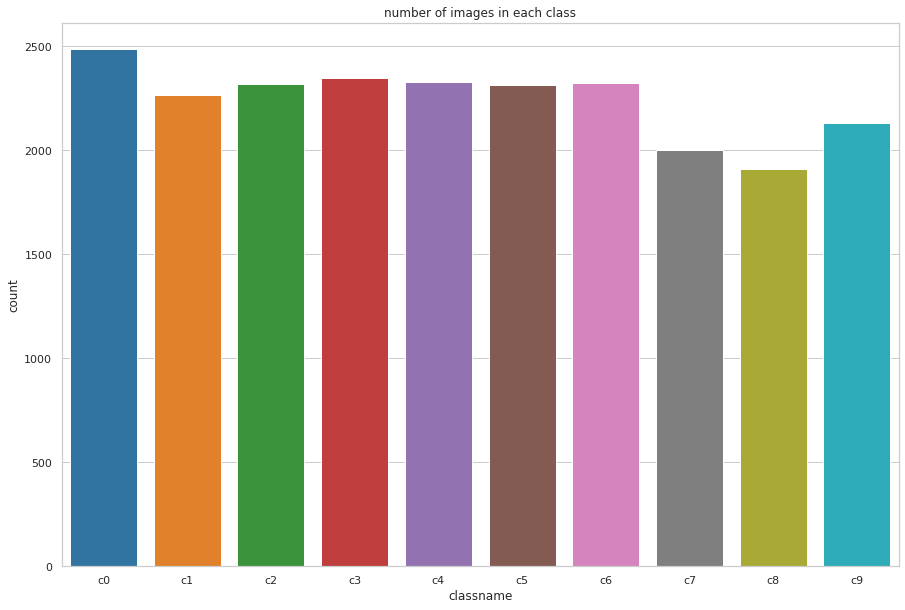

In [ ]:
sns.set_theme(font="Microsoft YaHei",style="whitegrid",palette=sns.color_palette("tab10"))
plt.figure(figsize=(15,10))
plt.title('number of images in each class')
sns.countplot(x = 'classname',data=driver_info)
plt.show()

Below shows the number of images contributed by different participants.

In [ ]:
df = pd.DataFrame((driver_info['subject'].value_counts()).reset_index())
df.columns = ['id', 'counts']
df.T

0     1     2     3     4     5     6     7     8     9   ...    16  \
id      p021  p022  p024  p026  p016  p066  p049  p051  p014  p015  ...  p061   
counts  1237  1233  1226  1196  1078  1034  1011   920   876   875  ...   809   

          17    18    19    20    21    22    23    24    25  
id      p056  p050  p052  p002  p045  p039  p041  p042  p072  
counts   794   790   740   725   724   651   605   591   346  

[2 rows x 26 columns]

## Driver-Image Distribution

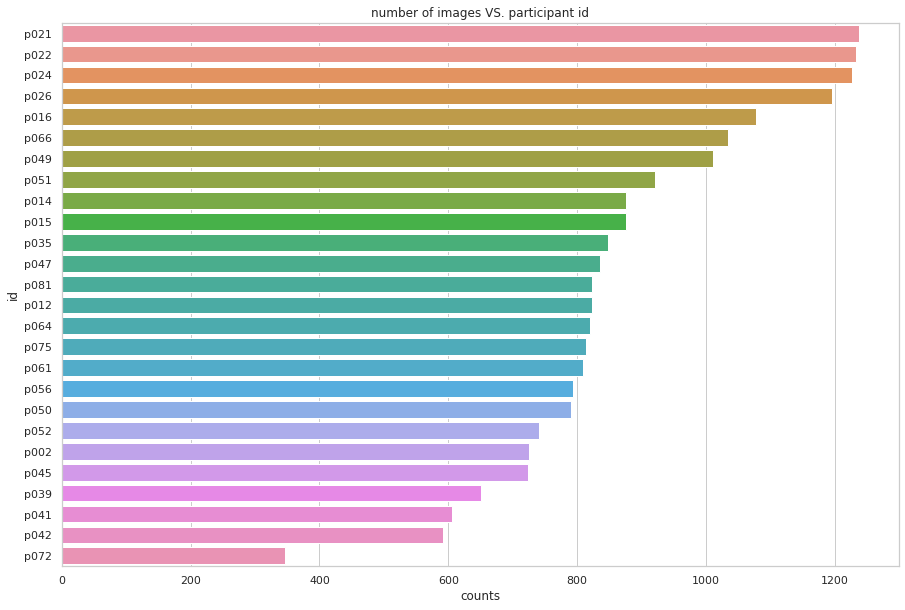

In [ ]:
plt.figure(figsize=(15,10))
plt.title('number of images VS. participant id')
driver_plot=sns.barplot(x="counts",y="id", data = df,orient="h")

To get an idea about the actual data, we are going to visualize the color and grey un-augmented images, as well as the images with augmentation techniques.

The augmentation includes Random Perspective, Auto Augmentation, Pad, and Random Erasing. We tried to add flipping as well but that didn't help since it may cause confusion when our model tries to distinguish between left and right(eg.texting left, texting right)



## Image Samples (Greyscale)

The original data was in color, but a greyscale visualization helps in depicting the differences in angle and position of the seated drivers.

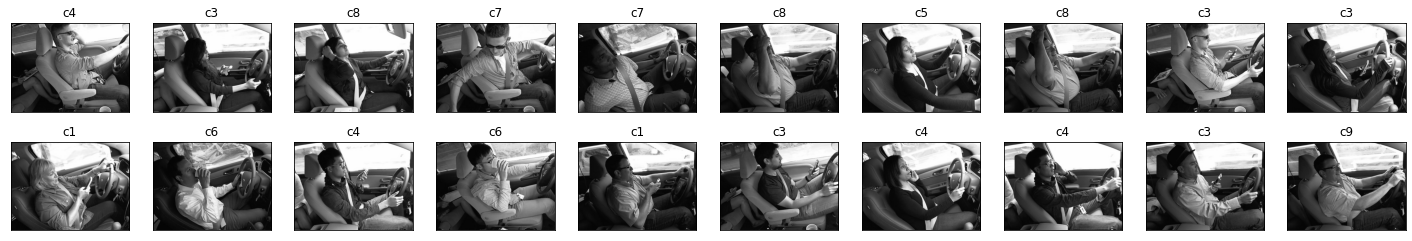

In [ ]:
transform = transforms.Compose([
                    transforms.Grayscale(num_output_channels=3),
                    transforms.ToTensor(),
                ])
train_set_aug = torchvision.datasets.ImageFolder(train_folder, transform=transform)
# Prepare Dataloader
batch_size = 128
num_workers = 0
data_loader = torch.utils.data.DataLoader(train_set_aug, batch_size=batch_size,num_workers=num_workers, shuffle=True)

# obtain one batch of training images
dataiter = iter(data_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
classes = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])



## Image Samples (Colored)

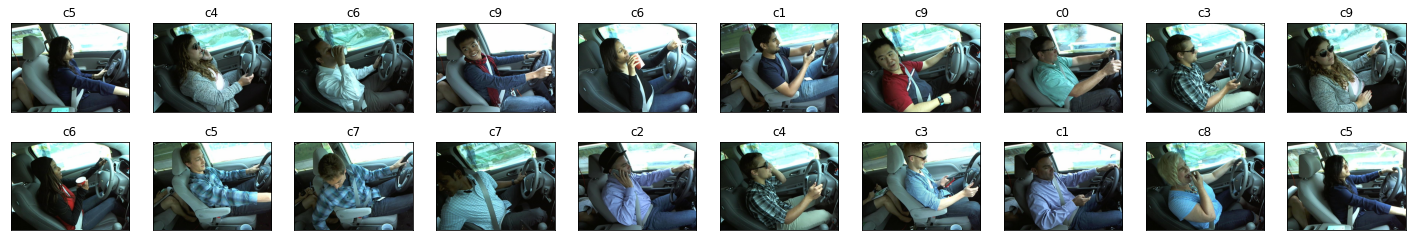

In [ ]:
transform = transforms.Compose([
                    transforms.ToTensor(),
                ])
train_set_aug = torchvision.datasets.ImageFolder(train_folder, transform=transform)
# Prepare Dataloader
batch_size = 128
num_workers = 0
data_loader = torch.utils.data.DataLoader(train_set_aug, batch_size=batch_size,num_workers=num_workers, shuffle=True)

# obtain one batch of training images
dataiter = iter(data_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
classes = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])


## Augmented Images (Colored)

The data augmentation techinque is only applied on the training data to prevent overfitting which is a severe problem in our project even with 17778 training images.

The transform parameter used in the following code was continuously modified to include/exclude different augmentation techniques.

percentage of training data is : 79.28112736353906%, 17778 images.
percentage of validation data is : 11.875668926150553%, 2663 images.
percentage of test data is : 8.843203710310382%, 1983 images.


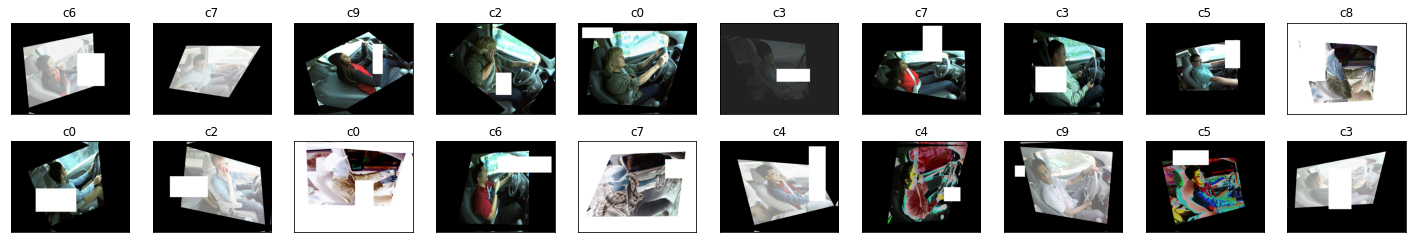

In [ ]:
mean = [0.4766, 0.4527, 0.3926]
std = [0.2275, 0.2224, 0.2210]
transform = transforms.Compose([
                    #transforms.RandomHorizontalFlip(p=0.2),
                    #transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
                    #transforms.Grayscale(num_output_channels=3),
                    transforms.RandomPerspective(distortion_scale=0.6, p=1),
                    transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
                    transforms.Pad(25, padding_mode='symmetric'),
                    #torchvision.transforms.ColorJitter(brightness=0.5, contrast=1, saturation=0.1, hue=0.5),
                    #transforms.RandomHorizontalFlip(),
                    #transforms.RandomRotation(10),
                    transforms.ToTensor(),
                    #transforms.Normalize(mean, std),
                    transforms.RandomErasing(p=0.8,scale=(0.01, 0.1),value=1.0, inplace=False)

                ])
transform_val = transforms.Compose([
                    transforms.ToTensor(),
                    #transforms.Normalize(mean, std)
                ])
train_set_aug = torchvision.datasets.ImageFolder(train_folder, transform=transform)
val_set_aug = torchvision.datasets.ImageFolder(val_folder, transform=transform_val)
test_set_aug = torchvision.datasets.ImageFolder(test_folder, transform=transform_val)
# Prepare Dataloader
batch_size = 128
num_workers = 0
data_loader = torch.utils.data.DataLoader(train_set_aug, batch_size=batch_size,num_workers=num_workers, shuffle=True)

# obtain one batch of training images
dataiter = iter(data_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
#images = 1 / (1 + np.exp(-images))
#images=np.clip(images, 0, 1)
classes = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])


total_size = len(train_set_aug) + len(val_set_aug) + len(test_set_aug)
print(f"percentage of training data is : {(len(train_set_aug)/ total_size) * 100}%, {len(train_set_aug)} images.")
print(f"percentage of validation data is : {(len(val_set_aug)/ total_size) * 100}%, {len(val_set_aug)} images.")
print(f"percentage of test data is : {(len(test_set_aug)/ total_size) * 100}%, {len(test_set_aug)} images.")



# Helper Functions

In [ ]:
# transfer learning

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
def get_loaders(batch_size, augmentation=False):
    if augmentation == False:
      train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
      val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
      test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

    elif augmentation == True:
      train_loader = torch.utils.data.DataLoader(train_set_aug, batch_size=batch_size, shuffle=True)
      val_loader = torch.utils.data.DataLoader(val_set_aug, batch_size=batch_size, shuffle=True)
      test_loader = torch.utils.data.DataLoader(test_set_aug, batch_size=batch_size, shuffle=True)

    return train_loader,val_loader,test_loader

Normal training method(eg.training code in lab2) will cause cuda out of memory problem because of 2 reasons: 1.the size of our dataset 2.The normal method upload train data to cuda twice and val data to cuda once in an epoch. These 2 reasons together cause the above problem. A way to circumvent this problem is to reduce the data uploaded to cuda. The architecture of the below training code is inspired by the pytorch transfer learning [tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) written by [Sasank Chilamkurthy](https://chsasank.com/). Reducing the batch size also helps to mitigate this problem.

## Train Net Function

In [ ]:
def train(args, net=None):

    # load net
    if net is None:
        Net = globals()[args.model]
        net = Net()
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=args.learning_rate,weight_decay=1e-5)

    tmp_dir = "models/" + args.model + "/"
    gdrive_dir = ''
    if args.augmentation == False:
      gdrive_dir = "/content/gdrive/MyDrive/MIE1517/1517project/models/"+ args.model + "/"
    else:
      #gdrive_dir = "/content/gdrive/MyDrive/MIE1517/1517project/aug_models_grey/"+ args.model + "/"
      #gdrive_dir = "/content/gdrive/MyDrive/MIE1517/1517project/aug_models/"+ args.model + "/"
      gdrive_dir = "/content/gdrive/MyDrive/MIE1517/1517project/aug_models3/"+ args.model + "/"
    # create necessary directories for storing the models for each epoch
    if not os.path.exists(tmp_dir):
        os.makedirs(tmp_dir)
    if not os.path.exists(gdrive_dir):
        os.makedirs(gdrive_dir)

    train_loader,val_loader,_ = get_loaders(args.batch_size, args.augmentation)

    best_model_wts = copy.deepcopy(net.state_dict())
    best_acc = 0.0

    since = time.time()

    train_accs, train_losses, val_accs, val_losses = [], [], [], []

    loader = train_loader
    for epoch in range(args.num_epochs):
        print(f"epoch {epoch+1}/{args.num_epochs}")
        print('-' * 15)
        # treat the train and val phase separately
        # requires uploading train and val data to GPU only once for every epoch.
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
                loader = train_loader
            else:
                net.eval()
                loader = val_loader

            losses,correct = 0.0,0.0

            for imgs, labels in loader:
                imgs = imgs.to(device)
                labels = labels.to(device)

                #track history if only in train
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    out = net(imgs)
                    #_, preds = torch.max(outputs, 1)
                    pred = out.max(1, keepdim=True)[1]
                    loss = criterion(out, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                losses += loss.item() * imgs.size(0)
                #correct += torch.sum(pred == labels.data)
                correct += pred.eq(labels.view_as(pred)).sum().item()


            if phase == 'train':
                epoch_loss = losses / len(train_set)
                epoch_acc = correct / len(train_set)
                train_accs.append(epoch_acc)
                train_losses.append(epoch_loss)
            else:
                epoch_loss = losses / len(val_set)
                epoch_acc = correct / len(val_set)
                val_accs.append(epoch_acc)
                val_losses.append(epoch_loss)


            print(f"{phase} Loss: {epoch_loss:.4f} Acc:{epoch_acc:.4f}")
            # we want to keep the model with the best validation accuracy so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(net.state_dict())

            # save the models to tmp dir and also gdrive
            checkpoints_dir = tmp_dir + f"model_{net.name}_bs_{args.batch_size}_lr_{args.learning_rate}_epoch_{epoch}"
            torch.save(net.state_dict(), checkpoints_dir)
            copy_tree(tmp_dir, gdrive_dir)


    time_elapsed = time.time() - since
    print()
    print(f'Training complete in {int(time_elapsed // 60)} minutes {int(time_elapsed % 60)} seconds')
    print(f'Best val Accuracy: {best_acc}')

    # plot training curves
    plt.title("Training Curve")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.plot(np.arange(args.num_epochs), train_losses, label='train')
    plt.plot(np.arange(args.num_epochs), val_losses, label='val')
    plt.title("Train vs Validation Loss")
    plt.legend()
    plt.show()

    train_accs = np.array(train_accs)
    val_accs = np.array(val_accs)
    train_losses = np.array(train_losses)
    val_losses = np.array(val_losses)

    plt.title("Training Curve")
    plt.xlabel("epochs")
    plt.ylabel("Accuracy")
    plt.plot(np.arange(args.num_epochs), train_accs, label='train')
    plt.plot(np.arange(args.num_epochs), val_accs, label='val')
    plt.legend()
    plt.show()

    # load the best model weights and return the best model
    net.load_state_dict(best_model_wts)

    return net

In [ ]:
def model_evaluation(model, loader):

    model.eval()
    model.to(device)

    loss = 0.0
    corrects = 0
    num_samples = 0

    model_pred, true_label = [],[]
    for imgs, labels in loader:
        imgs  = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)

        corrects += torch.sum(preds == labels.data).item()
        num_samples += len(imgs)

        preds = list(preds.cpu().detach().numpy())
        label = list(labels.data.cpu().detach().numpy())
        #preds = list(preds.numpy())
        #label = list(labels.numpy())
        model_pred += preds
        true_label += label
    test_acc = corrects / num_samples

    return test_acc,model_pred,true_label

In [ ]:
# plot confusion matrix
def plot_cm(predictions,targets,title):
  cm = confusion_matrix(y_true=targets,y_pred=predictions)
  df_cm = pd.DataFrame(data=cm,columns=classes,index=classes)
  plt.figure(figsize = (10,7))
  sns.heatmap(df_cm,xticklabels=classes,yticklabels=classes,annot=True)
  plt.xlabel('predicted label')
  plt.ylabel('true label')
  plt.title(title)
  plt.show()

# Transfer Learning Models

We used five different Transfer Learning models, leveraging the pretrained networks provided by the torch library:


*   GoogleNet
*   VGG-16
*   AlexNet
*   ResNet
*   MobileNet

The model architectures are straightforward: The image is passed into the pretrained models, and the output embeddings are passed into one or two linear layers to produce the classification output (non-normalized class probabilities). One of the advantages of a lightweight architecture is that it may be optimized on the fly, and hence different architectures were used for the different networks.

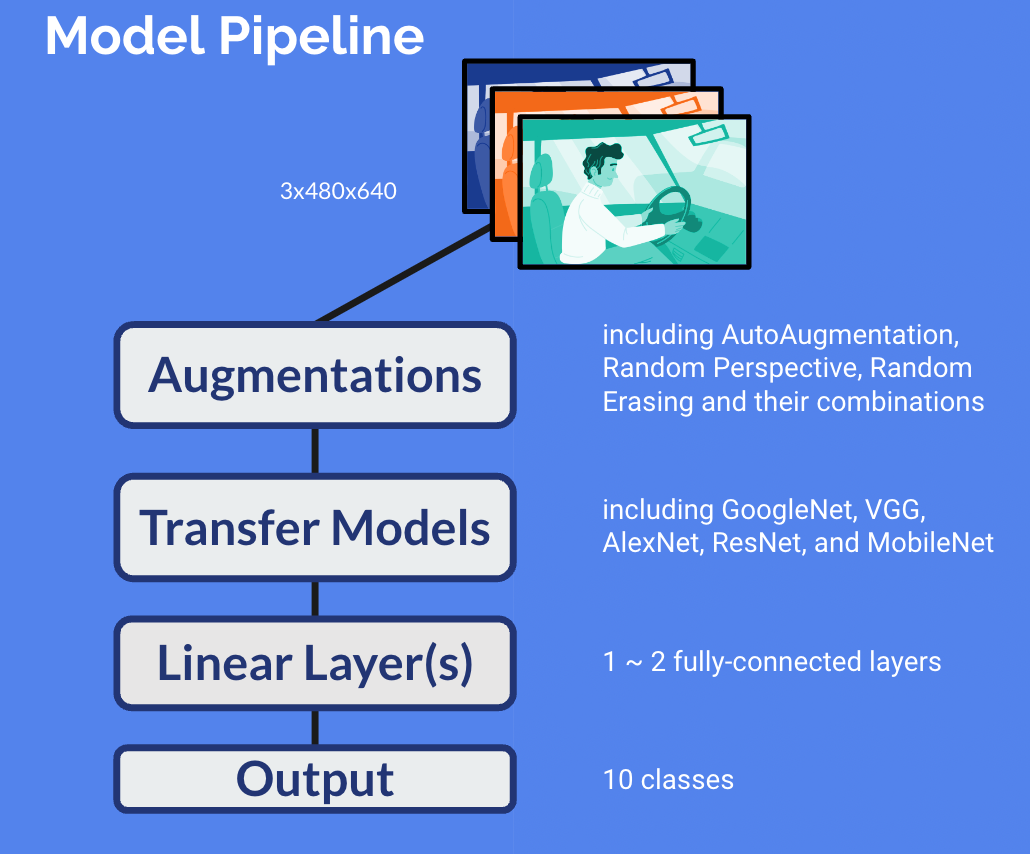

# Approach 1: Without Data Augmentation

As the first step, we test various transfer models with no data augmentation.
<br>The models we used are GoogleNet, VGG-16, AlexNet, ResNet, and MobileNet.

The default weight decay we used is 1e-6.

Observations: There are obvious overfitting issues even with dropout layers and weight decays. We will address the overfitting issue in the later sessions by applying various data augmentation techniques together with dropout layers and weight decay.

## Googlenet

In [ ]:
class Googlenet(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = 'Googlenet'

        self.cnn = models.googlenet(pretrained=True)
        self.fc1 = nn.Linear(1000, 256)
        self.fc2 = nn.Linear(256, 10)
        #self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.1)
    def forward(self, x):
        x = self.fc1(F.relu(self.cnn(x)))
        x = self.dropout(x)
        x = self.fc2(F.relu(x))
        return x
        #self.fc3(F.relu(x)x
        #return self.fc1(self.cnn(x))

epoch 1/5
---------------
train Loss: 0.2477 Acc:0.9235
val Loss: 0.9325 Acc:0.7236
epoch 2/5
---------------
train Loss: 0.0872 Acc:0.9759
val Loss: 1.7164 Acc:0.5261
epoch 3/5
---------------
train Loss: 0.0694 Acc:0.9797
val Loss: 1.4615 Acc:0.7304
epoch 4/5
---------------
train Loss: 0.0558 Acc:0.9854
val Loss: 1.0658 Acc:0.7386
epoch 5/5
---------------
train Loss: 0.0490 Acc:0.9878
val Loss: 0.6504 Acc:0.7976

Training complete in 49 minutes 52 seconds
Best val Accuracy: 0.7975966954562523


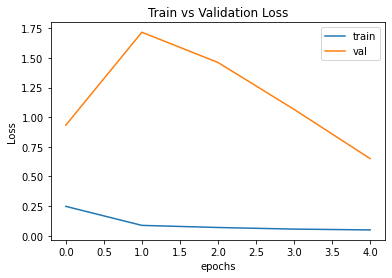

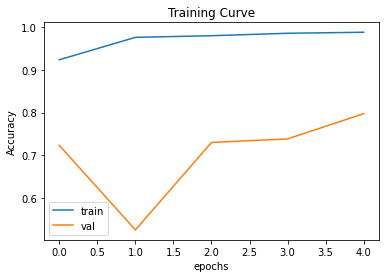

In [ ]:
args = AttrDict()
args_dict = {
    'model': "Googlenet",
    'augmentation': False,
    'num_epochs': 5,
    'batch_size': 32,
    'learning_rate': 0.001,
}
args.update(args_dict)
cnn = train(args)

Model result: overfitting issue found.

epoch 1/5
---------------
train Loss: 0.3567 Acc:0.8848
val Loss: 1.2825 Acc:0.6932
epoch 2/5
---------------
train Loss: 0.1386 Acc:0.9615
val Loss: 0.6023 Acc:0.8014
epoch 3/5
---------------
train Loss: 0.1052 Acc:0.9714
val Loss: 0.9286 Acc:0.7383
epoch 4/5
---------------
train Loss: 0.0848 Acc:0.9775
val Loss: 0.6513 Acc:0.8077
epoch 5/5
---------------
train Loss: 0.0669 Acc:0.9821
val Loss: 0.6419 Acc:0.8524

Training complete in 50 minutes 41 seconds
Best val Accuracy: 0.8524220803604957


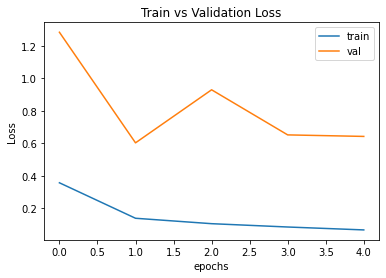

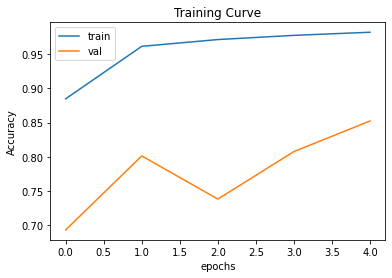

In [ ]:
# to prevent overfitting, the model complexity is reduced.
args = AttrDict()
args_dict = {
    'model': "Googlenet",
    'augmentation': False,
    'num_epochs': 5,
    'batch_size': 16,
    'learning_rate': 0.001,
}
args.update(args_dict)
cnn = train(args)

In [ ]:
googlenet = Googlenet()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/models/"
state = torch.load(save_to + f"{googlenet.name}/" +f"model_{googlenet.name}_bs_{args_dict['batch_size']}_lr_{args_dict['learning_rate']}_epoch_{args_dict['num_epochs']-2}")
googlenet.load_state_dict(state)

<All keys matched successfully>

## VGG

In [ ]:
class VGG16(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = 'vgg16'

        vgg = models.vgg16(pretrained = True)

        for param in vgg.parameters():
            param.requires_grad = False

        self.features = vgg.features
        self.conv1 = nn.Conv2d(512, 1024, 5, 3)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(1024 * 2 * 3, 32)
        self.fc2 = nn.Linear(32, 10)
        self.dropout = nn.Dropout(0.15)
        #self.fc3 = nn.Linear(128, 64)
        #self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.features(x) # torch.Size([32, 512, 15, 20])
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 1024 * 2 * 3)
        x = F.relu(self.fc1(x))
        #x = self.dropout(x)
        out = self.fc2(x)
        out = out.squeeze()

        return out

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

epoch 1/5
---------------
train Loss: 0.1959 Acc:0.9396
val Loss: 1.0516 Acc:0.6493
epoch 2/5
---------------
train Loss: 0.0070 Acc:0.9983
val Loss: 1.1731 Acc:0.7202
epoch 3/5
---------------
train Loss: 0.0176 Acc:0.9949
val Loss: 2.0701 Acc:0.5790
epoch 4/5
---------------
train Loss: 0.0102 Acc:0.9976
val Loss: 1.7202 Acc:0.5854
epoch 5/5
---------------
train Loss: 0.0055 Acc:0.9989
val Loss: 1.5750 Acc:0.6425

Training complete in 62 minutes 31 seconds
Best val Accuracy: 0.7202403304543747


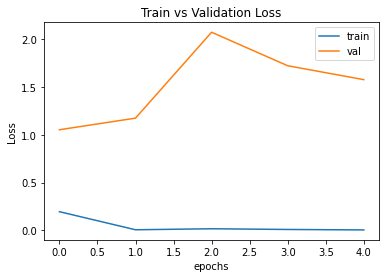

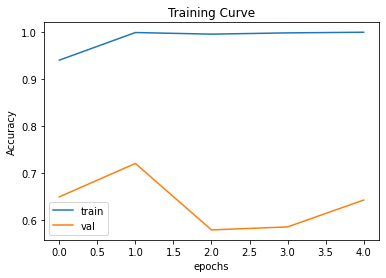

In [ ]:
args = AttrDict()
args_dict = {
    'model': "VGG16",
    'augmentation': False,
    'num_epochs': 5,
    'batch_size': 32,
    'learning_rate': 0.0001,
}
args.update(args_dict)
vgg16 = train(args)

Model result: overfitting issue found.

In [ ]:
vgg = VGG16()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/models/"
state = torch.load(save_to + f"{vgg.name}/" +f"model_{vgg.name}_bs_{args_dict['batch_size']}_lr_{args_dict['learning_rate']}_epoch_{args_dict['num_epochs']-1}")
vgg.load_state_dict(state)

## Alexnet

In [ ]:
class AlexClassifier(nn.Module):
    def __init__(self):
        super(AlexClassifier, self).__init__()

        self.name = 'alexnet'
        alexnet = torchvision.models.alexnet(pretrained=True)
        self.features=alexnet.features
        self.conv1 = nn.Conv2d(256, 128, 3, 2)
        self.pool = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(128 * 4 * 3, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.15)
    def forward(self, x):
        x = self.features(x)
        x = self.pool(F.relu(self.conv1(x)))

        x = x.view(-1, 128 * 4 * 3) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        output = self.fc2(x)
        out = output.squeeze()
        return out

epoch 1/8
---------------
train Loss: 0.7947 Acc:0.7735
val Loss: 2.2478 Acc:0.4315
epoch 2/8
---------------
train Loss: 0.0728 Acc:0.9846
val Loss: 2.6198 Acc:0.3992
epoch 3/8
---------------
train Loss: 0.0321 Acc:0.9934
val Loss: 2.6199 Acc:0.4337
epoch 4/8
---------------
train Loss: 0.0185 Acc:0.9966
val Loss: 3.1136 Acc:0.4232
epoch 5/8
---------------
train Loss: 0.0111 Acc:0.9975
val Loss: 2.6074 Acc:0.4412
epoch 6/8
---------------
train Loss: 0.0055 Acc:0.9989
val Loss: 3.5295 Acc:0.4157
epoch 7/8
---------------
train Loss: 0.0079 Acc:0.9979
val Loss: 3.2534 Acc:0.4472
epoch 8/8
---------------
train Loss: 0.0035 Acc:0.9995
val Loss: 3.3857 Acc:0.4465

Training complete in 35 minutes 43 seconds
Best val Accuracy: 0.4472399549380398


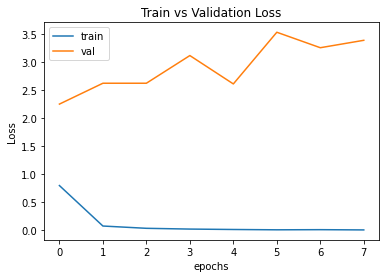

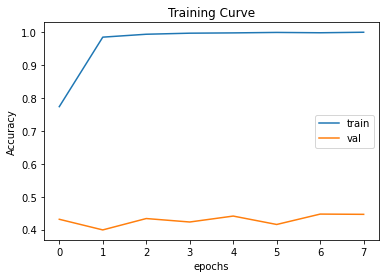

In [ ]:
args = AttrDict()
args_dict = {
    'model': "AlexClassifier",
    'augmentation': False,
    'num_epochs': 8,
    'batch_size': 16,
    'learning_rate': 0.002,
}
args.update(args_dict)
cnn = train(args)

Model result: overfitting issue found.

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

epoch 1/5
---------------
train Loss: 0.7804 Acc:0.7227
val Loss: 3.0685 Acc:0.4333
epoch 2/5
---------------
train Loss: 0.1064 Acc:0.9696
val Loss: 2.8106 Acc:0.4735
epoch 3/5
---------------
train Loss: 0.0696 Acc:0.9789
val Loss: 3.8234 Acc:0.4799
epoch 4/5
---------------
train Loss: 0.0607 Acc:0.9823
val Loss: 5.4422 Acc:0.4273
epoch 5/5
---------------
train Loss: 0.0479 Acc:0.9857
val Loss: 2.5476 Acc:0.5422

Training complete in 22 minutes 39 seconds
Best val Accuracy: 0.5422455876830642


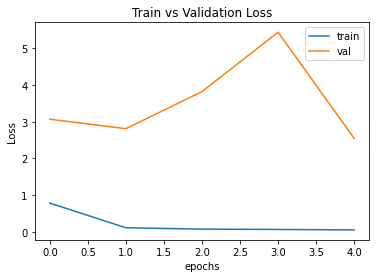

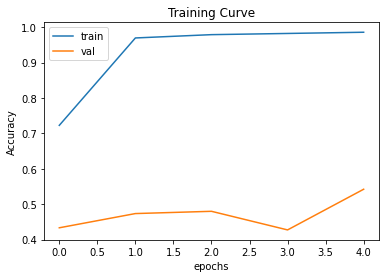

In [ ]:
args = AttrDict()
args_dict = {
    'model': "AlexClassifier",
    'augmentation': False,
    'num_epochs': 5,
    'batch_size': 16,
    'learning_rate': 0.0005,
}
args.update(args_dict)
cnn = train(args)

Model result: underfitting issue found.

Model result: overfitting issue found.

In [ ]:
alexnet = AlexClassifier()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/models/"
state = torch.load(save_to + f"{alexnet.name}/" +f"model_{alexnet.name}_bs_{args_dict['batch_size']}_lr_{args_dict['learning_rate']}_epoch_{args_dict['num_epochs']-1}")
alexnet.load_state_dict(state)

## Resnet

In [ ]:
class resnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = 'resnet'

        resnet = models.resnet18(pretrained=True)  # load Alexnet
        #for param in resnet.parameters():
            #param.requires_grad = False         # freeze all the network

        self.cnn = resnet
        self.fc = nn.Linear(1000,128)
        self.fc2 = nn.Linear(128,10)

    def forward(self, x):
        output = self.fc2(F.relu(self.fc(F.relu(self.cnn(x)))))
        output = output.squeeze()
        return output

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch 1/5
---------------
train Loss: 1.0762 Acc:0.6920
val Loss: 2.4041 Acc:0.3045
epoch 2/5
---------------
train Loss: 0.3494 Acc:0.9106
val Loss: 2.3850 Acc:0.3688
epoch 3/5
---------------
train Loss: 0.2264 Acc:0.9386
val Loss: 2.7130 Acc:0.3729
epoch 4/5
---------------
train Loss: 0.1733 Acc:0.9519
val Loss: 3.0915 Acc:0.3244
epoch 5/5
---------------
train Loss: 0.1378 Acc:0.9610
val Loss: 3.4398 Acc:0.3301

Training complete in 28 minutes 29 seconds
Best val Accuracy: 0.3728877206158468


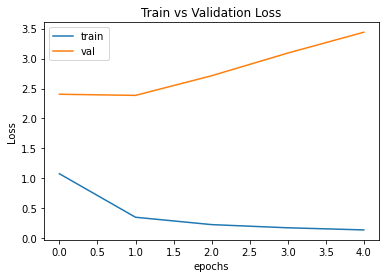

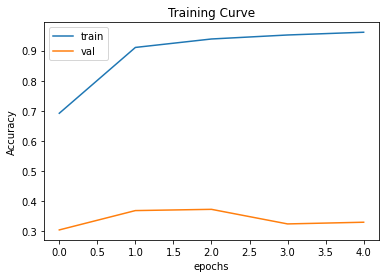

In [ ]:
args = AttrDict()
args_dict = {
    'model': "resnet",
    'augmentation': False,
    'num_epochs': 5,
    'batch_size': 64,
    'learning_rate': 0.001,
}
args.update(args_dict)
cnn = train(args)

Model result: overfitting issue found.

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch 1/5
---------------
train Loss: 0.8068 Acc:0.7085
val Loss: 1.6977 Acc:0.4912
epoch 2/5
---------------
train Loss: 0.2818 Acc:0.9114
val Loss: 1.0487 Acc:0.6478
epoch 3/5
---------------
train Loss: 0.1677 Acc:0.9527
val Loss: 1.5474 Acc:0.5415
epoch 4/5
---------------
train Loss: 0.1166 Acc:0.9695
val Loss: 1.1019 Acc:0.6887
epoch 5/5
---------------
train Loss: 0.0961 Acc:0.9758
val Loss: 1.8590 Acc:0.6192

Training complete in 40 minutes 27 seconds
Best val Accuracy: 0.6886969583176868


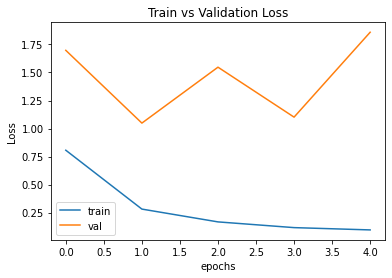

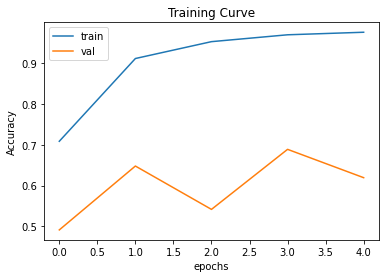

In [ ]:
args = AttrDict()
args_dict = {
    'model': "resnet",
    'augmentation': False,
    'num_epochs': 5,
    'batch_size': 16,
    'learning_rate': 0.002,
}
args.update(args_dict)
cnn = train(args)

In [ ]:
resnet = resnet()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/models/"
state = torch.load(save_to + f"{resnet.name}/" +f"model_{resnet.name}_bs_{args_dict['batch_size']}_lr_{args_dict['learning_rate']}_epoch_{args_dict['num_epochs']-1}")
resnet.load_state_dict(state)




## MobileNet

In [ ]:
class MobileNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = 'MobileNet'

        self.mobile = models.mobilenet_v2(pretrained=True)
        self.fc = nn.Linear(1000, 10)

    def forward(self, x):
        return self.fc(F.relu(self.mobile(x)))

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

epoch 1/5
---------------
train Loss: 0.2955 Acc:0.9058
val Loss: 0.9121 Acc:0.8089
epoch 2/5
---------------
train Loss: 0.1281 Acc:0.9623
val Loss: 1.1810 Acc:0.7582
epoch 3/5
---------------
train Loss: 0.0916 Acc:0.9735
val Loss: 0.8457 Acc:0.7807
epoch 4/5
---------------
train Loss: 0.0880 Acc:0.9753
val Loss: 0.5206 Acc:0.8412
epoch 5/5
---------------
train Loss: 0.0778 Acc:0.9777
val Loss: 0.9358 Acc:0.7998

Training complete in 50 minutes 14 seconds
Best val Accuracy: 0.8411565903116786


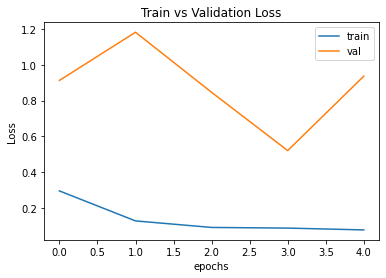

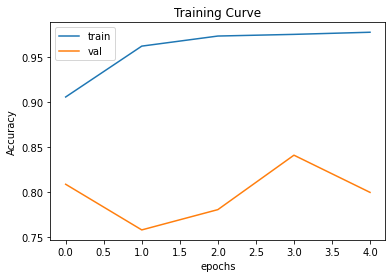

In [ ]:
args = AttrDict()
args_dict = {
    'model': "MobileNet",
    'augmentation': False,
    'num_epochs': 5,
    'batch_size': 16,
    'learning_rate': 0.001,
}
args.update(args_dict)
cnn = train(args)

Model result: overfitting issue found.

## Performance on Test Set


For each model, we have tried 1-2 hyper-parameter setting. Nearly all models have overfitting issue: models achieve almost 95+%, but have very low accuracy at the vailidation set. Having said that, the GoogleNet and MobileNet transfer models get 80% accuracy at validation set. Hence, we compare those two models on the test set.

In [ ]:
googlenet = Googlenet()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/models/"
state = torch.load(save_to + f"{googlenet.name}/" +f"model_{googlenet.name}_bs_{16}_lr_{0.001}_epoch_{4}")
googlenet.load_state_dict(state)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
mobilenet = MobileNet()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/models/"
state = torch.load(save_to + f"{mobilenet.name}/" +f"model_{mobilenet.name}_bs_{16}_lr_{0.001}_epoch_{3}")
mobilenet.load_state_dict(state)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
_,_,test_loader = get_loaders(batch_size=8)

In [ ]:
test_acc, test_preds, test_labels = model_evaluation(googlenet,test_loader)

In [ ]:
test_acc

0.6908724155320222

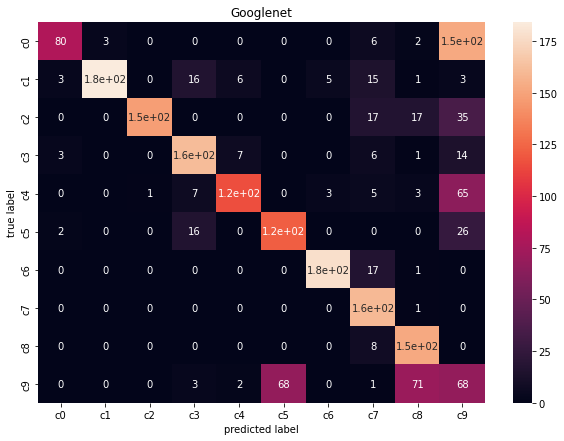

In [ ]:
plot_cm(test_preds,test_labels,'Googlenet')

In [ ]:
test_acc2, test_preds2, test_labels2 = model_evaluation(mobilenet,test_loader)

In [ ]:
test_acc2

0.7554210791729703

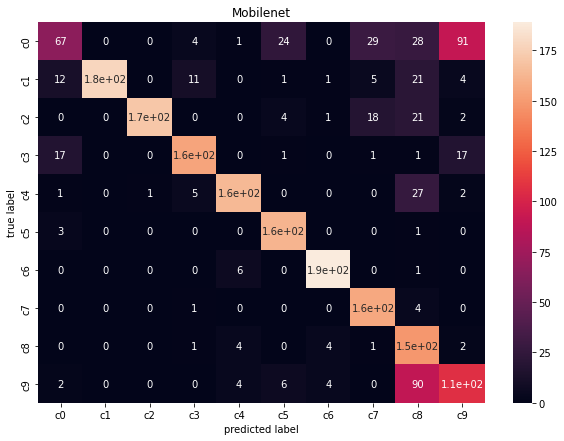

In [ ]:
plot_cm(test_preds2,test_labels2,'Mobilenet')

Genrally, both models (GoogleNet and MobileNet) have difficulties in predicting C0 (safe driving) and C9 (talking to passenger). By the heatmaps above, GoogleNet predicts C0 to be C9 over 60% instances, and mistakenly predicts C9 with C5 (operating the radio), C8 (hair and makeup). While MobileNet has lower ability predicting C0, and the wrong predictions covers the classes of C5, C7 (reaching behind), C8, C9.

To mitigate the overfitting problem, we explored if data augmentation helps at later sections.

# Approach 2: Data augmentation using only ImageNet AutoAugment Policy

The ImageNet AutoAugment Policy is a set of random transformations and filters (available in the torchvision package) that can be applied to produce a greater variety of images in the hopes of training a better generalizing model. Refer to Torchvision documentation for details.

Observations: We still have overfitting issues in our models. It seems that applying ImageNet AutoAugment is not enough.

## Googlenet

In [ ]:
class Googlenet(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = 'Googlenet'

        self.cnn = models.googlenet(pretrained=True)
        self.fc1 = nn.Linear(1000, 256)
        self.fc2 = nn.Linear(256, 10)
        #self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.1)
    def forward(self, x):
        x = self.fc1(F.relu(self.cnn(x)))
        x = self.dropout(x)
        x = self.fc2(F.relu(x))
        return x
        #self.fc3(F.relu(x)x
        #return self.fc1(self.cnn(x))

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

epoch 1/5
---------------
train Loss: 0.5494 Acc:0.8216
val Loss: 1.3296 Acc:0.6725
epoch 2/5
---------------
train Loss: 0.2115 Acc:0.9395
val Loss: 0.6542 Acc:0.8017
epoch 3/5
---------------
train Loss: 0.1654 Acc:0.9522
val Loss: 0.6850 Acc:0.8243
epoch 4/5
---------------
train Loss: 0.1566 Acc:0.9567
val Loss: 0.9424 Acc:0.7555
epoch 5/5
---------------
train Loss: 0.1110 Acc:0.9690
val Loss: 1.0876 Acc:0.7285

Training complete in 53 minutes 52 seconds
Best val Accuracy: 0.8242583552384529


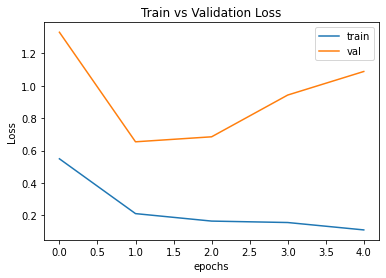

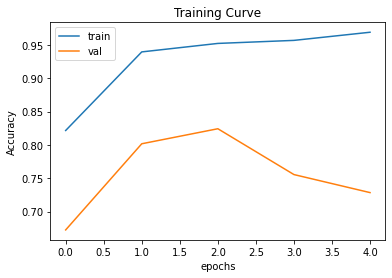

In [ ]:
args = AttrDict()
args_dict = {
    'model': "Googlenet",
    'augmentation': True,
    'num_epochs': 5,
    'batch_size': 16,
    'learning_rate': 0.001,
}
args.update(args_dict)
cnn = train(args)
# results: overfitting

Model result: overfitting issue found.

## VGG

In [ ]:
class VGG16(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = 'vgg16'

        vgg = models.vgg16(pretrained = True)

        for param in vgg.parameters():
            param.requires_grad = False

        self.features = vgg.features
        self.conv1 = nn.Conv2d(512, 1024, 5, 3)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(1024 * 2 * 3, 32)
        self.fc2 = nn.Linear(32, 10)
        self.dropout = nn.Dropout(0.15)
        #self.fc3 = nn.Linear(128, 64)
        #self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.features(x) # torch.Size([32, 512, 15, 20])
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 1024 * 2 * 3)
        x = F.relu(self.fc1(x))
        #x = self.dropout(x)
        out = self.fc2(x)
        out = out.squeeze()

        return out

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

epoch 1/5
---------------
train Loss: 0.7680 Acc:0.7833
val Loss: 1.4778 Acc:0.5524
epoch 2/5
---------------
train Loss: 0.1244 Acc:0.9790
val Loss: 1.6857 Acc:0.5077
epoch 3/5
---------------
train Loss: 0.0650 Acc:0.9876
val Loss: 1.5593 Acc:0.5595
epoch 4/5
---------------
train Loss: 0.0435 Acc:0.9915
val Loss: 1.6041 Acc:0.5509
epoch 5/5
---------------
train Loss: 0.0320 Acc:0.9930
val Loss: 1.3776 Acc:0.6173

Training complete in 73 minutes 29 seconds
Best val Accuracy: 0.6173488546751784


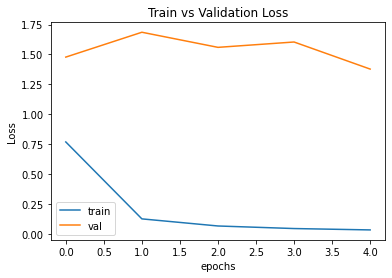

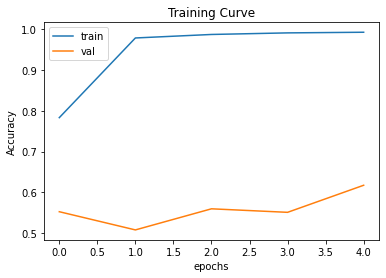

In [ ]:
args = AttrDict()
args_dict = {
    'model': "VGG16",
    'augmentation': True,
    'num_epochs': 5,
    'batch_size': 32,
    'learning_rate': 0.0001,
}
args.update(args_dict)
vgg16 = train(args)

epoch 1/5
---------------
train Loss: 0.4578 Acc:0.8662
val Loss: 1.6601 Acc:0.4953
epoch 2/5
---------------
train Loss: 0.0747 Acc:0.9813
val Loss: 1.7078 Acc:0.5389
epoch 3/5
---------------
train Loss: 0.0505 Acc:0.9865
val Loss: 1.6430 Acc:0.5561
epoch 4/5
---------------
train Loss: 0.0435 Acc:0.9885
val Loss: 1.7968 Acc:0.5268
epoch 5/5
---------------
train Loss: 0.0349 Acc:0.9913
val Loss: 1.4336 Acc:0.6027

Training complete in 71 minutes 13 seconds
Best val Accuracy: 0.6027037176117161


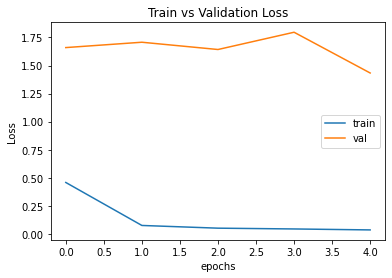

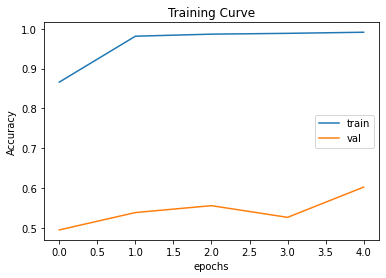

In [ ]:
args = AttrDict()
args_dict = {
    'model': "VGG16",
    'augmentation': True,
    'num_epochs': 5,
    'batch_size': 16,
    'learning_rate': 0.0002,
}
args.update(args_dict)
vgg16 = train(args)

## Alexnet

In [ ]:
class AlexClassifier(nn.Module):
    def __init__(self):
        super(AlexClassifier, self).__init__()

        self.name = 'alexnet'
        alexnet = torchvision.models.alexnet(pretrained=True)
        self.features=alexnet.features
        self.conv1 = nn.Conv2d(256, 128, 3, 2)
        self.pool = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(128 * 4 * 3, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.15)
    def forward(self, x):
        x = self.features(x)
        x = self.pool(F.relu(self.conv1(x)))

        x = x.view(-1, 128 * 4 * 3) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        output = self.fc2(x)
        out = output.squeeze()
        return out

epoch 1/5
---------------
train Loss: 2.3010 Acc:0.1020
val Loss: 2.3039 Acc:0.1006
epoch 2/5
---------------
train Loss: 2.3013 Acc:0.1090
val Loss: 2.3041 Acc:0.1112
epoch 3/5
---------------
train Loss: 2.3003 Acc:0.1083
val Loss: 2.3048 Acc:0.1112
epoch 4/5
---------------
train Loss: 2.3005 Acc:0.1075
val Loss: 2.3044 Acc:0.1112
epoch 5/5
---------------
train Loss: 2.2997 Acc:0.1065
val Loss: 2.3045 Acc:0.1003

Training complete in 26 minutes 27 seconds
Best val Accuracy: 0.11115283514832895


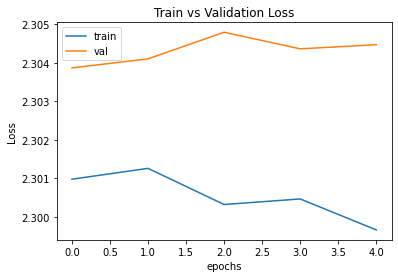

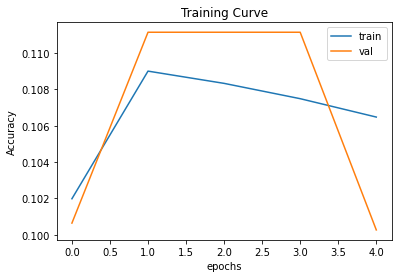

In [ ]:
args = AttrDict()
args_dict = {
    'model': "AlexClassifier",
    'augmentation': True,
    'num_epochs': 5,
    'batch_size': 16,
    'learning_rate': 0.001,
}
args.update(args_dict)
cnn = train(args)

## Resnet

In [ ]:
class resnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = 'resnet'

        resnet = models.resnet18(pretrained=True)  # load Alexnet
        #for param in resnet.parameters():
            #param.requires_grad = False         # freeze all the network

        self.cnn = resnet
        self.fc = nn.Linear(1000,128)
        self.fc2 = nn.Linear(128,10)

    def forward(self, x):
        output = self.fc2(F.relu(self.fc(F.relu(self.cnn(x)))))
        output = output.squeeze()
        return output

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch 1/5
---------------
train Loss: 2.3023 Acc:0.1089
val Loss: 2.3038 Acc:0.1112
epoch 2/5
---------------
train Loss: 2.2998 Acc:0.1073
val Loss: 2.3046 Acc:0.1003
epoch 3/5
---------------
train Loss: 2.3011 Acc:0.1087
val Loss: 2.3042 Acc:0.1112
epoch 4/5
---------------
train Loss: 2.3004 Acc:0.1105
val Loss: 2.3044 Acc:0.1006
epoch 5/5
---------------
train Loss: 2.2998 Acc:0.1090
val Loss: 2.3041 Acc:0.1112

Training complete in 43 minutes 7 seconds
Best val Accuracy: 0.11115283514832895


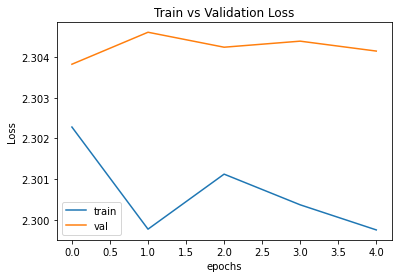

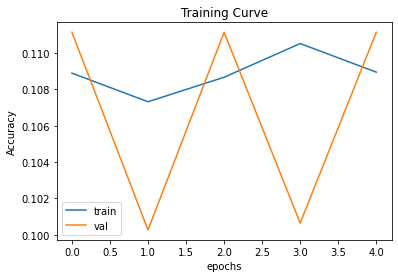

In [ ]:
args = AttrDict()
args_dict = {
    'model': "resnet",
    'augmentation': True,
    'num_epochs': 5,
    'batch_size': 16,
    'learning_rate': 0.002,
}
args.update(args_dict)
cnn = train(args)

epoch 1/5
---------------
train Loss: 0.3927 Acc:0.8741
val Loss: 0.9466 Acc:0.7559
epoch 2/5
---------------
train Loss: 0.1440 Acc:0.9560
val Loss: 2.7917 Acc:0.4352
epoch 3/5
---------------
train Loss: 0.0989 Acc:0.9700
val Loss: 2.2692 Acc:0.5884
epoch 4/5
---------------
train Loss: 0.0773 Acc:0.9779
val Loss: 0.8206 Acc:0.7687
epoch 5/5
---------------
train Loss: 0.0731 Acc:0.9794
val Loss: 0.9567 Acc:0.7435

Training complete in 42 minutes 43 seconds
Best val Accuracy: 0.7686819376642884


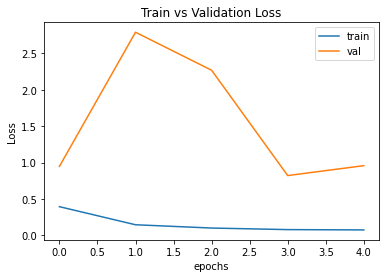

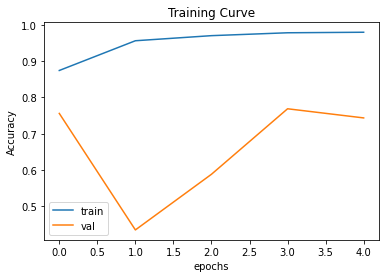

In [ ]:
args = AttrDict()
args_dict = {
    'model': "resnet",
    'augmentation': True,
    'num_epochs': 5,
    'batch_size': 32,
    'learning_rate': 0.001,
}
args.update(args_dict)
cnn = train(args)

## MobileNet

In [ ]:
class MobileNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = 'MobileNet'

        self.mobile = models.mobilenet_v2(pretrained=True)
        self.fc = nn.Linear(1000, 10)

    def forward(self, x):
        return self.fc(F.relu(self.mobile(x)))

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

epoch 1/5
---------------
train Loss: 0.4622 Acc:0.8485
val Loss: 0.6730 Acc:0.8265
epoch 2/5
---------------
train Loss: 0.2169 Acc:0.9361
val Loss: 1.3117 Acc:0.7127
epoch 3/5
---------------
train Loss: 0.1553 Acc:0.9547
val Loss: 0.8089 Acc:0.7830
epoch 4/5
---------------
train Loss: 0.1397 Acc:0.9589
val Loss: 0.9871 Acc:0.7214
epoch 5/5
---------------
train Loss: 0.1167 Acc:0.9656
val Loss: 0.8458 Acc:0.7893

Training complete in 53 minutes 0 seconds
Best val Accuracy: 0.8265114532482163


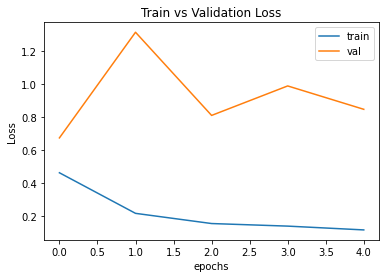

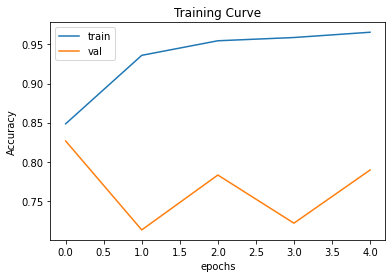

In [ ]:
args = AttrDict()
args_dict = {
    'model': "MobileNet",
    'augmentation': True,
    'num_epochs': 5,
    'batch_size': 16,
    'learning_rate': 0.001,
}
args.update(args_dict)
cnn = train(args)

## Performance on Test Set

We still have overfitting issues in our models. It seems that applying ImageNet AutoAugment is not enough.

In [ ]:
googlenet = Googlenet()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/aug_models2/"
state = torch.load(save_to + f"{googlenet.name}/" +f"model_{googlenet.name}_bs_{16}_lr_{0.001}_epoch_{2}")
googlenet.load_state_dict(state)

<All keys matched successfully>

In [ ]:
mobilenet = MobileNet()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/aug_models2/"
state = torch.load(save_to + f"{mobilenet.name}/" +f"model_{mobilenet.name}_bs_{16}_lr_{0.001}_epoch_{0}")
mobilenet.load_state_dict(state)

<All keys matched successfully>

In [ ]:
_,_,test_loader = get_loaders(batch_size=8)

In [ ]:
test_acc, test_preds, test_labels = model_evaluation(googlenet,test_loader)

In [ ]:
test_acc

0.7771053958648513

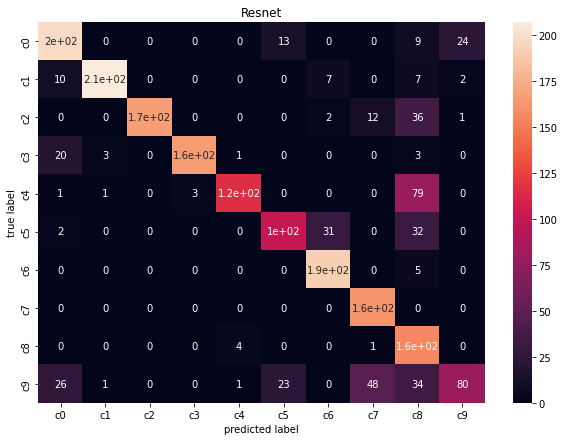

In [ ]:
plot_cm(test_preds,test_labels,'googlenet')

In [ ]:
test_acc2, test_preds2, test_labels2 = model_evaluation(mobilenet,test_loader)

In [ ]:
test_acc2

0.7786182551689359

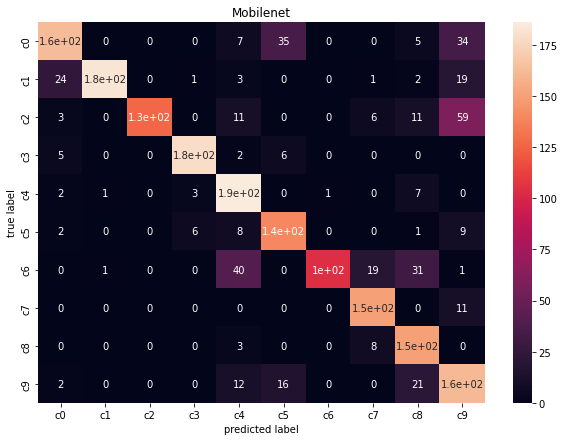

In [ ]:
plot_cm(test_preds2,test_labels2,'Mobilenet')

With the augmentation of only AutoAugment, the accuracy of both MobileNet and GoogleNet increase by 2% - 5%. We found that they have relatively good performance over most classes. However, the GoogleNet still has difficulties identifying C9.

# Approach 3: Data Augmentation using ImageNet AutoAugment + Random Perspectives + Random Erasing

The models are re-trained using more sophisticated augmentation techniques. Refer to the Augmentation Code in the Augmented Images section.

Observations: We can see that the degree of overfitting is greatly reduced by deploy the above data augmentation combination. The random erasing technique is especially important in addressing overfitting. But still we need to set early stopping points to choose the model with the suitable level of complexity right before it overfits.

## Googlenet

In [ ]:
class Googlenet(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = 'Googlenet'

        self.cnn = models.googlenet(pretrained=True)
        self.fc1 = nn.Linear(1000, 128)
        self.fc2 = nn.Linear(128, 10)
        #self.fc3 = nn.Linear(64, 10)
        #self.dropout = nn.Dropout(0.15)
        self.dropout = nn.Dropout(0.1)
        #self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        x = self.fc1(F.relu(self.cnn(x)))
        x = self.dropout(x)
        x = self.fc2(F.relu(x))
        return x
        #self.fc3(F.relu(x)x
        #return self.fc1(self.cnn(x))

### with random erasing

epoch 1/8
---------------
train Loss: 1.5568 Acc:0.3815
val Loss: 1.4890 Acc:0.4412
epoch 2/8
---------------
train Loss: 0.8016 Acc:0.6941
val Loss: 1.0910 Acc:0.7202
epoch 3/8
---------------
train Loss: 0.4941 Acc:0.8354
val Loss: 0.9078 Acc:0.7642
epoch 4/8
---------------
train Loss: 0.3496 Acc:0.8936
val Loss: 0.7619 Acc:0.8115
epoch 5/8
---------------
train Loss: 0.2808 Acc:0.9143
val Loss: 0.8950 Acc:0.7552
epoch 6/8
---------------
train Loss: 0.2322 Acc:0.9311
val Loss: 0.9819 Acc:0.7480
epoch 7/8
---------------
train Loss: 0.2049 Acc:0.9390
val Loss: 1.1839 Acc:0.7499
epoch 8/8
---------------
train Loss: 0.1814 Acc:0.9459
val Loss: 1.4394 Acc:0.6737

Training complete in 127 minutes 59 seconds
Best val Accuracy: 0.8114907998497934


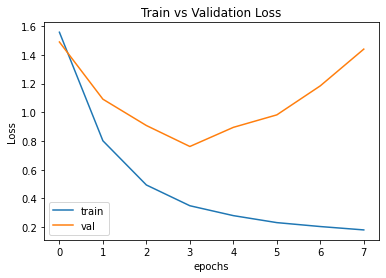

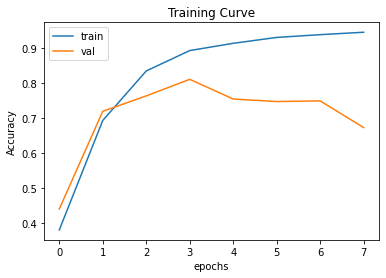

In [ ]:
# with random erasing
args = AttrDict()
args_dict = {
    'model': "Googlenet",
    'augmentation': True,
    'num_epochs': 8,
    'batch_size': 16,
    'learning_rate': 0.0005,
}
args.update(args_dict)
cnn = train(args)

Model result: overfitting issue found.

epoch 1/6
---------------
train Loss: 1.5470 Acc:0.3999
val Loss: 1.7555 Acc:0.4720
epoch 2/6
---------------
train Loss: 0.8449 Acc:0.6882
val Loss: 0.8051 Acc:0.7567
epoch 3/6
---------------
train Loss: 0.5575 Acc:0.8084
val Loss: 1.6292 Acc:0.6256
epoch 4/6
---------------
train Loss: 0.3994 Acc:0.8761
val Loss: 1.3228 Acc:0.6376
epoch 5/6
---------------
train Loss: 0.3334 Acc:0.8962
val Loss: 0.7343 Acc:0.8201
epoch 6/6
---------------
train Loss: 0.2834 Acc:0.9121
val Loss: 0.7280 Acc:0.7811

Training complete in 91 minutes 26 seconds
Best val Accuracy: 0.8201276755538865


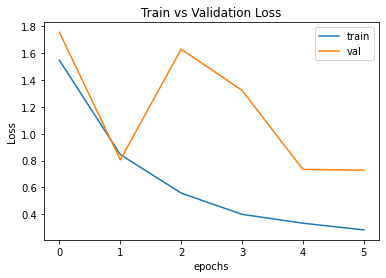

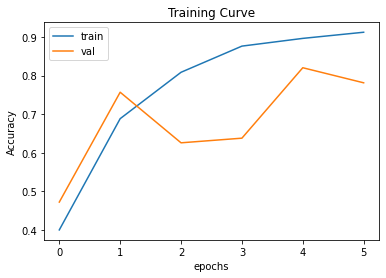

In [ ]:
# with random erasing
args = AttrDict()
args_dict = {
    'model': "Googlenet",
    'augmentation': True,
    'num_epochs': 6,
    'batch_size': 32,
    'learning_rate': 0.001,
}
args.update(args_dict)
cnn = train(args)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

epoch 1/6
---------------
train Loss: 0.8627 Acc:0.6915
val Loss: 1.9411 Acc:0.6373
epoch 2/6
---------------
train Loss: 0.2596 Acc:0.9182
val Loss: 1.1353 Acc:0.7709
epoch 3/6
---------------
train Loss: 0.1912 Acc:0.9402
val Loss: 2.3334 Acc:0.6714
epoch 4/6
---------------
train Loss: 0.1635 Acc:0.9478
val Loss: 1.0226 Acc:0.7709
epoch 5/6
---------------
train Loss: 0.1340 Acc:0.9585
val Loss: 0.9414 Acc:0.8021
epoch 6/6
---------------
train Loss: 0.1389 Acc:0.9569
val Loss: 1.0954 Acc:0.7462

Training complete in 94 minutes 8 seconds
Best val Accuracy: 0.8021028914757792


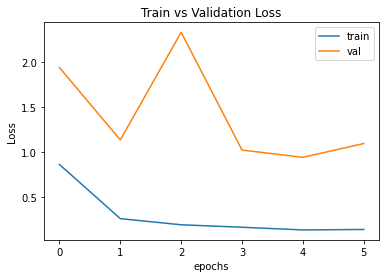

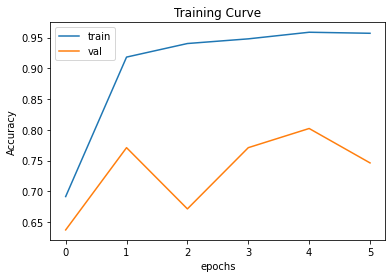

In [ ]:
# with random erasing
args = AttrDict()
args_dict = {
    'model': "Googlenet",
    'augmentation': True,
    'num_epochs': 6,
    'batch_size': 32,
    'learning_rate': 0.0005,
}
args.update(args_dict)
cnn = train(args)

epoch 1/6
---------------
train Loss: 0.7315 Acc:0.7437
val Loss: 1.6924 Acc:0.6515
epoch 2/6
---------------
train Loss: 0.1695 Acc:0.9479
val Loss: 1.2275 Acc:0.7420
epoch 3/6
---------------
train Loss: 0.1255 Acc:0.9616
val Loss: 1.5966 Acc:0.7533
epoch 4/6
---------------
train Loss: 0.0965 Acc:0.9702
val Loss: 1.8173 Acc:0.6557
epoch 5/6
---------------
train Loss: 0.0888 Acc:0.9718
val Loss: 1.3943 Acc:0.6996
epoch 6/6
---------------
train Loss: 0.0794 Acc:0.9751
val Loss: 1.9075 Acc:0.6680

Training complete in 93 minutes 34 seconds
Best val Accuracy: 0.753285767930905


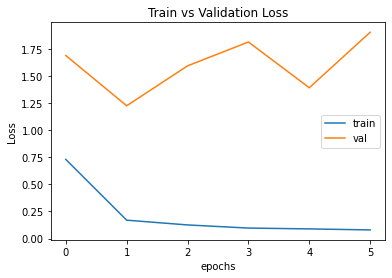

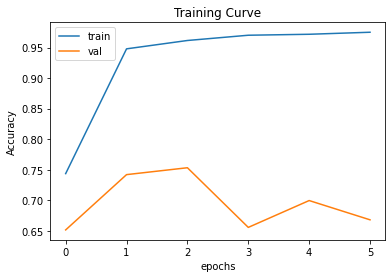

In [ ]:
# with random erasing
args = AttrDict()
args_dict = {
    'model': "Googlenet",
    'augmentation': True,
    'num_epochs': 6,
    'batch_size': 32,
    'learning_rate': 0.0002,
}
args.update(args_dict)
cnn = train(args)

### without random erasing

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

epoch 1/8
---------------
train Loss: 0.7284 Acc:0.7410
val Loss: 1.5405 Acc:0.6819
epoch 2/8
---------------
train Loss: 0.2468 Acc:0.9228
val Loss: 2.8494 Acc:0.5633
epoch 3/8
---------------
train Loss: 0.1806 Acc:0.9474
val Loss: 1.4404 Acc:0.7484
epoch 4/8
---------------
train Loss: 0.1453 Acc:0.9558
val Loss: 1.9255 Acc:0.6876
epoch 5/8
---------------
train Loss: 0.1226 Acc:0.9653
val Loss: 0.6867 Acc:0.8325
epoch 6/8
---------------
train Loss: 0.1047 Acc:0.9711
val Loss: 0.9093 Acc:0.8179
epoch 7/8
---------------
train Loss: 0.1050 Acc:0.9711
val Loss: 0.8746 Acc:0.7912
epoch 8/8
---------------
train Loss: 0.0893 Acc:0.9759
val Loss: 0.9683 Acc:0.8010

Training complete in 131 minutes 3 seconds
Best val Accuracy: 0.8325197146075854


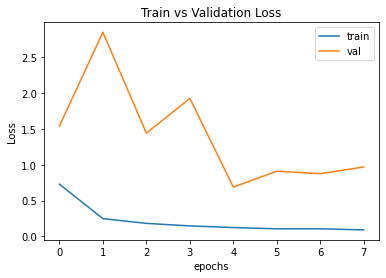

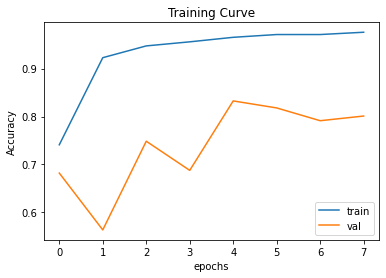

In [ ]:
# without random erasing
args = AttrDict()
args_dict = {
    'model': "Googlenet",
    'augmentation': True,
    'num_epochs': 8,
    'batch_size': 16,
    'learning_rate': 0.0005,
}
args.update(args_dict)
cnn = train(args)

epoch 1/7
---------------
train Loss: 1.1678 Acc:0.5704
val Loss: 0.7096 Acc:0.7646
epoch 2/7
---------------
train Loss: 0.3906 Acc:0.8793
val Loss: 0.8954 Acc:0.7946
epoch 3/7
---------------
train Loss: 0.2602 Acc:0.9247
val Loss: 0.9762 Acc:0.7555
epoch 4/7
---------------
train Loss: 0.2050 Acc:0.9404
val Loss: 0.9222 Acc:0.7856
epoch 5/7
---------------
train Loss: 0.1829 Acc:0.9487
val Loss: 0.8385 Acc:0.7991
epoch 6/7
---------------
train Loss: 0.1354 Acc:0.9611
val Loss: 1.1227 Acc:0.7244
epoch 7/7
---------------
train Loss: 0.1220 Acc:0.9647
val Loss: 0.6971 Acc:0.8246

Training complete in 113 minutes 34 seconds
Best val Accuracy: 0.8246338715734134


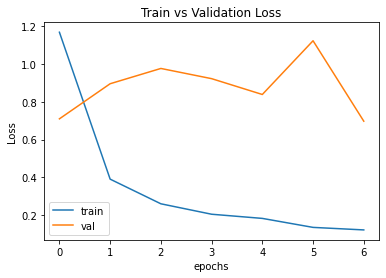

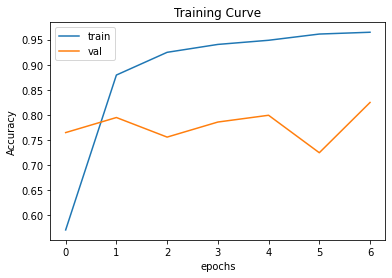

In [ ]:
args = AttrDict()
args_dict = {
    'model': "Googlenet",
    'augmentation': True,
    'num_epochs': 7,
    'batch_size': 32,
    'learning_rate': 0.001,
}
args.update(args_dict)
cnn = train(args)

## Alexnet

In [ ]:
class AlexClassifier(nn.Module):
    def __init__(self):
        super(AlexClassifier, self).__init__()

        self.name = 'alexnet'
        alexnet = torchvision.models.alexnet(pretrained=True)
        self.features=alexnet.features
        self.conv1 = nn.Conv2d(256, 128, 3, 2)
        self.pool = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(128 * 4 * 3, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.15)
    def forward(self, x):
        x = self.features(x)
        x = self.pool(F.relu(self.conv1(x)))

        x = x.view(-1, 128 * 4 * 3) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        output = self.fc2(x)
        out = output.squeeze()
        return out

In [ ]:
args = AttrDict()
args_dict = {
    'model': "AlexClassifier",
    'augmentation': True,
    'num_epochs': 5,
    'batch_size': 32,
    'learning_rate': 0.0005,
}
args.update(args_dict)
cnn = train(args)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

epoch 1/5
---------------
train Loss: 2.3012 Acc:0.1029
val Loss: 2.3037 Acc:0.1006
epoch 2/5
---------------
train Loss: 2.2999 Acc:0.1064
val Loss: 2.3035 Acc:0.1112
epoch 3/5
---------------
train Loss: 2.2997 Acc:0.1057
val Loss: 2.3037 Acc:0.1112
epoch 4/5
---------------


KeyboardInterrupt: ignored

## Resnet

In [ ]:
class resnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = 'resnet'

        resnet = models.resnet18(pretrained=True)

        self.cnn = resnet
        self.fc = nn.Linear(1000,10)
        #self.fc2 = nn.Linear(128,10)

    def forward(self, x):
        output = (self.fc(F.relu(self.cnn(x))))
        output = output.squeeze()
        return output

In [ ]:
args = AttrDict()
args_dict = {
    'model': "resnet",
    'augmentation': True,
    'num_epochs': 8,
    'batch_size': 32,
    'learning_rate': 0.001,
}
args.update(args_dict)
cnn = train(args)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch 1/8
---------------
train Loss: 1.6955 Acc:0.3484
val Loss: 1.6022 Acc:0.4225
epoch 2/8
---------------
train Loss: 0.7597 Acc:0.7221
val Loss: 0.8710 Acc:0.7559
epoch 3/8
---------------
train Loss: 0.4250 Acc:0.8617
val Loss: 2.0051 Acc:0.6181
epoch 4/8
---------------
train Loss: 0.3006 Acc:0.9040
val Loss: 1.3808 Acc:0.6906
epoch 5/8
---------------
train Loss: 0.2591 Acc:0.9154
val Loss: 2.2333 Acc:0.4885
epoch 6/8
---------------
train Loss: 0.2273 Acc:0.9274
val Loss: 2.3547 Acc:0.6241
epoch 7/8
---------------


## Mobilenet

In [ ]:
class MobileNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = 'MobileNet'

        self.mobile = models.mobilenet_v2(pretrained=True)
        self.fc = nn.Linear(1000, 10)

    def forward(self, x):
        return self.fc(F.relu(self.mobile(x)))

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

epoch 1/7
---------------
train Loss: 1.0605 Acc:0.6196
val Loss: 2.0791 Acc:0.5896
epoch 2/7
---------------
train Loss: 0.4872 Acc:0.8431
val Loss: 0.9381 Acc:0.7458
epoch 3/7
---------------
train Loss: 0.3617 Acc:0.8869
val Loss: 2.2174 Acc:0.6031
epoch 4/7
---------------
train Loss: 0.3232 Acc:0.8975
val Loss: 1.1719 Acc:0.7544
epoch 5/7
---------------
train Loss: 0.2737 Acc:0.9125
val Loss: 1.2779 Acc:0.6801
epoch 6/7
---------------
train Loss: 0.2371 Acc:0.9247
val Loss: 1.2382 Acc:0.7503
epoch 7/7
---------------
train Loss: 0.2292 Acc:0.9302
val Loss: 1.4560 Acc:0.7394

Training complete in 114 minutes 28 seconds
Best val Accuracy: 0.7544123169357867


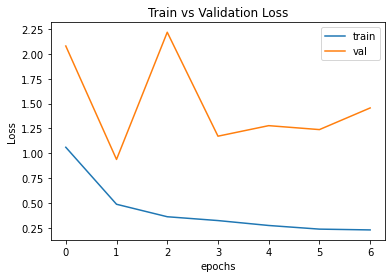

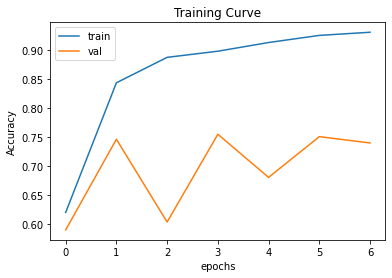

In [ ]:
args = AttrDict()
args_dict = {
    'model': "MobileNet",
    'augmentation': True,
    'num_epochs': 7,
    'batch_size': 16,
    'learning_rate': 0.001,
}
args.update(args_dict)
cnn = train(args)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

epoch 1/6
---------------
train Loss: 0.6846 Acc:0.7712
val Loss: 1.2484 Acc:0.7056
epoch 2/6
---------------
train Loss: 0.2592 Acc:0.9189
val Loss: 1.0324 Acc:0.7769
epoch 3/6
---------------
train Loss: 0.2072 Acc:0.9349
val Loss: 1.6056 Acc:0.7048
epoch 4/6
---------------
train Loss: 0.1860 Acc:0.9416
val Loss: 1.0418 Acc:0.7908
epoch 5/6
---------------
train Loss: 0.1575 Acc:0.9496
val Loss: 1.7761 Acc:0.6962
epoch 6/6
---------------
train Loss: 0.1447 Acc:0.9548
val Loss: 0.7737 Acc:0.8412

Training complete in 96 minutes 13 seconds
Best val Accuracy: 0.8411565903116786


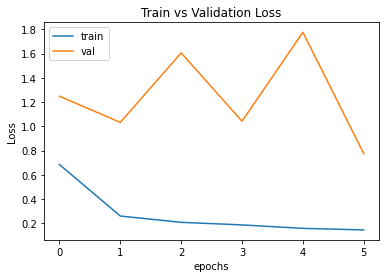

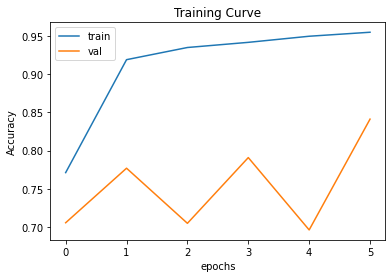

In [ ]:
args = AttrDict()
args_dict = {
    'model': "MobileNet",
    'augmentation': True,
    'num_epochs': 6,
    'batch_size': 16,
    'learning_rate': 0.0005,
}
args.update(args_dict)
cnn = train(args)

### without random erasing

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

epoch 1/6
---------------
train Loss: 0.4926 Acc:0.8400
val Loss: 0.9860 Acc:0.7938
epoch 2/6
---------------
train Loss: 0.1731 Acc:0.9484
val Loss: 1.0454 Acc:0.7574
epoch 3/6
---------------
train Loss: 0.1394 Acc:0.9596
val Loss: 0.7989 Acc:0.8100
epoch 4/6
---------------
train Loss: 0.1078 Acc:0.9676
val Loss: 0.9945 Acc:0.7548
epoch 5/6
---------------
train Loss: 0.0993 Acc:0.9709
val Loss: 1.2784 Acc:0.7428
epoch 6/6
---------------
train Loss: 0.0917 Acc:0.9739
val Loss: 1.9295 Acc:0.6864

Training complete in 100 minutes 38 seconds
Best val Accuracy: 0.8099887345099512


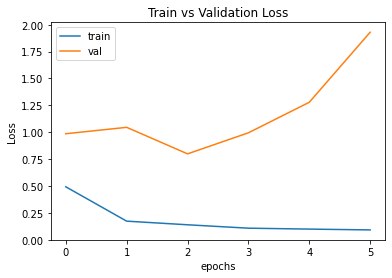

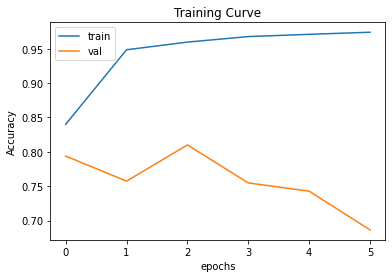

In [ ]:
args = AttrDict()
args_dict = {
    'model': "MobileNet",
    'augmentation': True,
    'num_epochs': 6,
    'batch_size': 16,
    'learning_rate': 0.0005,
}
args.update(args_dict)
cnn = train(args)

Model result: overfitting issue found.

### ensamble model

In [ ]:
### ensamble model

In [ ]:
class MyEnsemble(nn.Module):

    def __init__(self, modelA, modelB, modelC, input):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC

        self.fc1 = nn.Linear(input, 10)

    def forward(self, x):
        out1 = self.modelA(x)
        out2 = self.modelB(x)
        out3 = self.modelC(x)

        out = out1 + out2 + out3

        x = self.fc1(out)
        return torch.softmax(x, dim=1)

In [ ]:
model = MyEnsemble(densenet, resnet, incept, 10)

## performance on test set

### model with random erasing

In [ ]:
googlenet = Googlenet()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/aug_models/"
state = torch.load(save_to + f"{googlenet.name}/" +f"model_{googlenet.name}_bs_{16}_lr_{0.0005}_epoch_{3}")
googlenet.load_state_dict(state)

<All keys matched successfully>

In [ ]:
mobilenet = MobileNet()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/aug_models/"
state = torch.load(save_to + f"{mobilenet.name}/" +f"model_{mobilenet.name}_bs_{16}_lr_{0.0005}_epoch_{5}")
mobilenet.load_state_dict(state)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
googlenet2 = Googlenet()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/aug_models/"
state = torch.load(save_to + f"{googlenet2.name}/" +f"model_{googlenet2.name}_bs_{32}_lr_{0.001}_epoch_{5}")
googlenet2.load_state_dict(state)

<All keys matched successfully>

In [ ]:
_,_,test_loader = get_loaders(batch_size=8)

In [ ]:
test_acc, test_preds, test_labels = model_evaluation(googlenet,test_loader)

In [ ]:
test_acc

0.7599596570852244

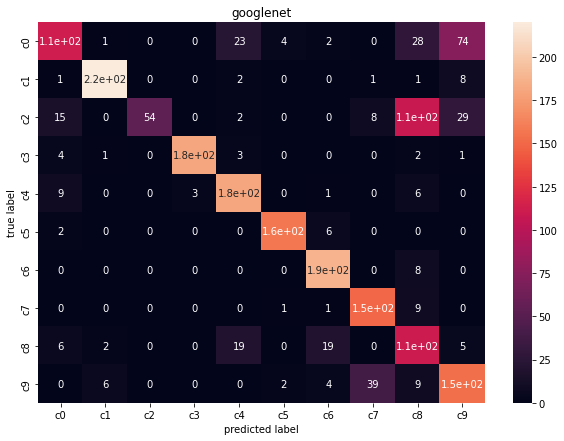

In [ ]:
plot_cm(test_preds,test_labels,'googlenet')

In [ ]:
test_acc2, test_preds2, test_labels2 = model_evaluation(mobilenet,test_loader)

In [ ]:
test_acc2

0.7236510337871911

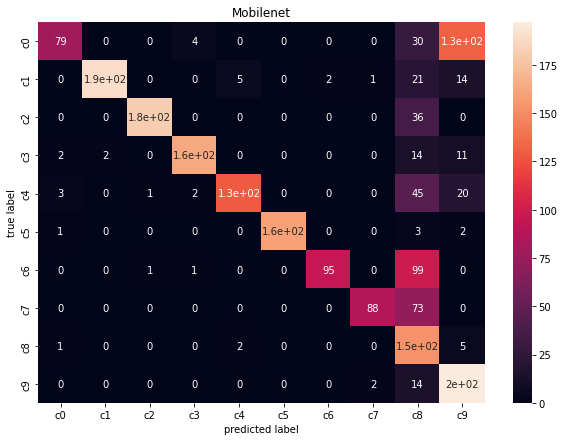

In [ ]:
plot_cm(test_preds2,test_labels2,'Mobilenet')

In [ ]:
test_acc3, test_preds3, test_labels3 = model_evaluation(googlenet2,test_loader)

In [ ]:
test_acc3

0.6828038325769037

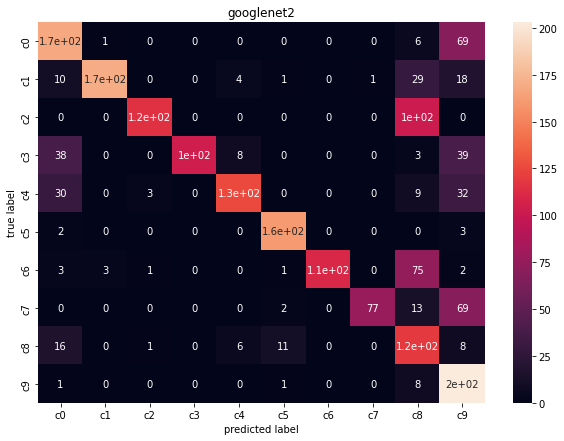

In [ ]:
plot_cm(test_preds3,test_labels3,'googlenet2')

### model without random erasing

In [ ]:
googlenet = Googlenet()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/aug_models2/"
state = torch.load(save_to + f"{googlenet.name}/" +f"model_{googlenet.name}_bs_{16}_lr_{0.0005}_epoch_{4}")
googlenet.load_state_dict(state)

<All keys matched successfully>

In [ ]:
googlenet2 = Googlenet()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/aug_models2/"
state = torch.load(save_to + f"{googlenet.name}/" +f"model_{googlenet.name}_bs_{32}_lr_{0.001}_epoch_{1}")
googlenet.load_state_dict(state)

<All keys matched successfully>

In [ ]:
mobilenet = MobileNet()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/aug_models2/"
state = torch.load(save_to + f"{mobilenet.name}/" +f"model_{mobilenet.name}_bs_{16}_lr_{0.0005}_epoch_{2}")
mobilenet.load_state_dict(state)

<All keys matched successfully>

In [ ]:
_,_,test_loader = get_loaders(batch_size=8)

In [ ]:
test_acc, test_preds, test_labels = model_evaluation(googlenet,test_loader)

In [ ]:
test_acc

0.713565305093293

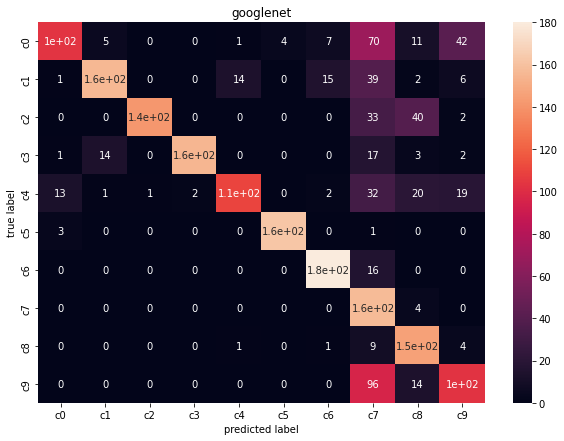

In [ ]:
plot_cm(test_preds,test_labels,'googlenet')

In [ ]:
test_acc2, test_preds2, test_labels2 = model_evaluation(googlenet2,test_loader)

In [ ]:
test_acc2

0.12708018154311648

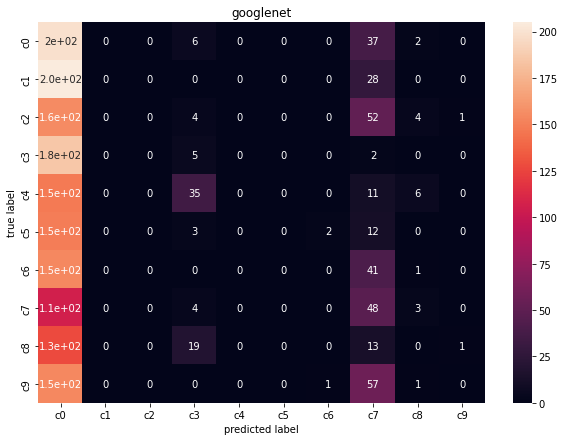

In [ ]:
plot_cm(test_preds2,test_labels2,'googlenet')

In [ ]:
test_acc3, test_preds3, test_labels3 = model_evaluation(mobilenet,test_loader)

In [ ]:
test_acc3

0.697428139183056

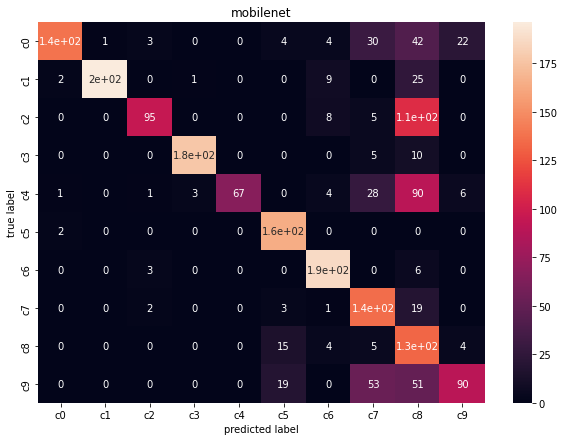

In [ ]:
plot_cm(test_preds3,test_labels3,'mobilenet')

# Approach 4: Ensemble Model (Failed)

In [ ]:
def model_evaluation2(model, loader):

    model.eval()
    model.to(device)
    corrects = 0
    num_samples = 0


    model_pred, true_label = [],[]
    for imgs, labels in loader:
        imgs  = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)

        corrects += torch.sum(preds == labels.data).item()
        num_samples += len(imgs)

        preds = list(preds.cpu().detach().numpy())
        label = list(labels.data.cpu().detach().numpy())
        #preds = list(preds.numpy())
        #label = list(labels.numpy())
        model_pred += preds
        true_label += label
    test_acc = corrects / num_samples

    return test_acc,model_pred,true_label

In [ ]:
def plot_cm(predictions,targets,title):
  cm = confusion_matrix(y_true=targets,y_pred=predictions)
  df_cm = pd.DataFrame(data=cm,columns=classes,index=classes)
  plt.figure(figsize = (10,7))
  sns.heatmap(df_cm,xticklabels=classes,yticklabels=classes,annot=True)
  plt.xlabel('predicted label')
  plt.ylabel('true label')
  plt.title(title)
  plt.show()

In [ ]:
class MyEnsemble(nn.Module):

    def __init__(self, modelA, modelB, modelC, input):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC

        self.fc1 = nn.Linear(input, 10)

    def forward(self, x):
        out1 = self.modelA(x)
        out2 = self.modelB(x)
        out3 = self.modelC(x)

        out = out1 + out2 + out3

        x = self.fc1(out)
        return x

In [ ]:
googlenet = Googlenet()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/aug_models/"
state = torch.load(save_to + f"{googlenet.name}/" +f"model_{googlenet.name}_bs_{16}_lr_{0.0005}_epoch_{3}")
googlenet.load_state_dict(state)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
mobilenet = MobileNet()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/aug_models/"
state = torch.load(save_to + f"{mobilenet.name}/" +f"model_{mobilenet.name}_bs_{16}_lr_{0.0005}_epoch_{5}")
mobilenet.load_state_dict(state)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
googlenet2 = Googlenet()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/aug_models/"
state = torch.load(save_to + f"{googlenet2.name}/" +f"model_{googlenet2.name}_bs_{32}_lr_{0.001}_epoch_{5}")
googlenet2.load_state_dict(state)

<All keys matched successfully>

In [ ]:
model = MyEnsemble(googlenet, mobilenet, googlenet2, 10)

In [ ]:
_,_,test_loader = get_loaders(batch_size=8)

In [ ]:
test_acc, test_preds, test_labels = model_evaluation2(model,test_loader)

RuntimeError: ignored

Unfortunately, we cannot test out our ensemble model due to cuda memory limit.

# Apporach 5: Models using larger weight decay(1e-5) + ImageNet AutoAugment + Random Perspectives

We can see that a larger weight decay with random perspective also addresses the overfitting issue quite nicely. We will compare the performance of models on the new data to determine which augmentation setting can make the models generalize better on unseen dataset.

## googlenet

In [ ]:
# with random erasing
args = AttrDict()
args_dict = {
    'model': "Googlenet",
    'augmentation': True,
    'num_epochs': 8,
    'batch_size': 16,
    'learning_rate': 0.0005,
}
args.update(args_dict)
cnn = train(args)

epoch 1/8
---------------
train Loss: 2.3034 Acc:0.1024
val Loss: 2.3042 Acc:0.1112
epoch 2/8
---------------
train Loss: 2.3013 Acc:0.1075
val Loss: 2.3089 Acc:0.1003
epoch 3/8
---------------


KeyboardInterrupt: ignored

epoch 1/8
---------------
train Loss: 1.9948 Acc:0.2018
val Loss: 2.1353 Acc:0.1941
epoch 2/8
---------------
train Loss: 1.4091 Acc:0.4331
val Loss: 0.9322 Acc:0.6309
epoch 3/8
---------------
train Loss: 0.9222 Acc:0.6583
val Loss: 0.9768 Acc:0.6557
epoch 4/8
---------------
train Loss: 0.7025 Acc:0.7461
val Loss: 0.9147 Acc:0.7266
epoch 5/8
---------------
train Loss: 0.5526 Acc:0.8034
val Loss: 0.9022 Acc:0.7495
epoch 6/8
---------------
train Loss: 0.4485 Acc:0.8539
val Loss: 0.8948 Acc:0.7522
epoch 7/8
---------------
train Loss: 0.3924 Acc:0.8760
val Loss: 1.7621 Acc:0.6759
epoch 8/8
---------------
train Loss: 0.3376 Acc:0.8953
val Loss: 0.7379 Acc:0.8213

Training complete in 126 minutes 2 seconds
Best val Accuracy: 0.8212542245587683


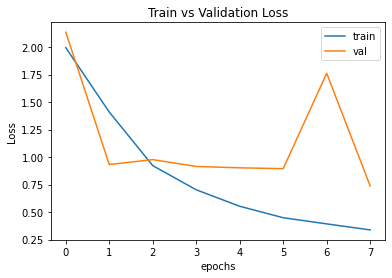

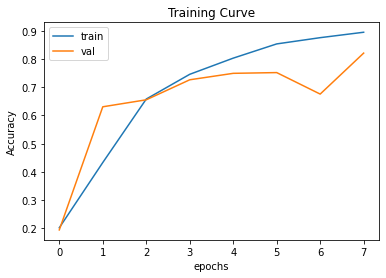

In [ ]:
# with random erasing
args = AttrDict()
args_dict = {
    'model': "Googlenet",
    'augmentation': True,
    'num_epochs': 8,
    'batch_size': 32,
    'learning_rate': 0.001,
}
args.update(args_dict)
cnn = train(args)

## Mobilenet

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

epoch 1/7
---------------
train Loss: 1.8118 Acc:0.2740
val Loss: 1.9881 Acc:0.2929
epoch 2/7
---------------
train Loss: 0.9572 Acc:0.6444
val Loss: 1.9740 Acc:0.5738
epoch 3/7
---------------
train Loss: 0.5849 Acc:0.8018
val Loss: 1.1504 Acc:0.7285
epoch 4/7
---------------
train Loss: 0.4597 Acc:0.8500
val Loss: 1.1721 Acc:0.7477
epoch 5/7
---------------
train Loss: 0.3955 Acc:0.8708
val Loss: 3.7230 Acc:0.5216
epoch 6/7
---------------
train Loss: 0.3440 Acc:0.8914
val Loss: 2.1925 Acc:0.6583
epoch 7/7
---------------
train Loss: 0.3626 Acc:0.8846
val Loss: 1.8524 Acc:0.6500

Training complete in 116 minutes 21 seconds
Best val Accuracy: 0.7476530229064964


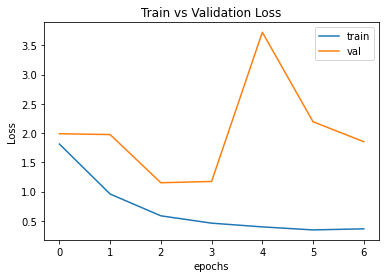

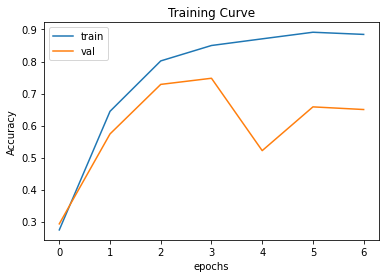

In [ ]:
args = AttrDict()
args_dict = {
    'model': "MobileNet",
    'augmentation': True,
    'num_epochs': 7,
    'batch_size': 16,
    'learning_rate': 0.001,
}
args.update(args_dict)
cnn = train(args)

Model result: overfitting issue found.

## Resnet

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch 1/8
---------------
train Loss: 1.5395 Acc:0.4220
val Loss: 2.2477 Acc:0.4311
epoch 2/8
---------------
train Loss: 0.6410 Acc:0.7775
val Loss: 0.7985 Acc:0.7912
epoch 3/8
---------------
train Loss: 0.4063 Acc:0.8667
val Loss: 2.1842 Acc:0.6541
epoch 4/8
---------------
train Loss: 0.3243 Acc:0.8949
val Loss: 1.5586 Acc:0.7187
epoch 5/8
---------------
train Loss: 0.2622 Acc:0.9161
val Loss: 1.8318 Acc:0.6797
epoch 6/8
---------------
train Loss: 0.2286 Acc:0.9258
val Loss: 0.9627 Acc:0.7600
epoch 7/8
---------------
train Loss: 0.1959 Acc:0.9360
val Loss: 2.8875 Acc:0.4904
epoch 8/8
---------------
train Loss: 0.1836 Acc:0.9394
val Loss: 1.1595 Acc:0.7683

Training complete in 112 minutes 30 seconds
Best val Accuracy: 0.7912129177619226


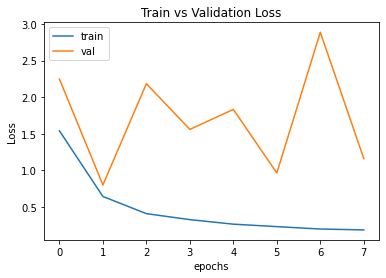

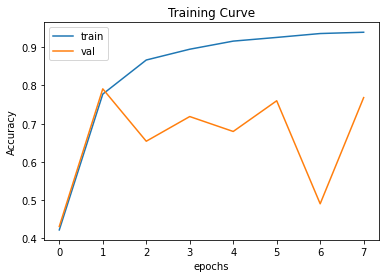

In [ ]:
args = AttrDict()
args_dict = {
    'model': "resnet",
    'augmentation': True,
    'num_epochs': 8,
    'batch_size': 32,
    'learning_rate': 0.001,
}
args.update(args_dict)
cnn = train(args)

Model result: overfitting issue found.

## performance on test set

In [ ]:
googlenet = Googlenet()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/aug_models3/"
state = torch.load(save_to + f"{googlenet.name}/" +f"model_{googlenet.name}_bs_{32}_lr_{0.001}_epoch_{7}")
googlenet.load_state_dict(state)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
mobilenet = MobileNet()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/aug_models3/"
state = torch.load(save_to + f"{mobilenet.name}/" +f"model_{mobilenet.name}_bs_{16}_lr_{0.001}_epoch_{3}")
mobilenet.load_state_dict(state)

<All keys matched successfully>

In [ ]:
googlenet2 = Googlenet()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/aug_models3/"
state = torch.load(save_to + f"{googlenet.name}/" +f"model_{googlenet.name}_bs_{32}_lr_{0.001}_epoch_{5}")
googlenet2.load_state_dict(state)

<All keys matched successfully>

In [ ]:
_,_,test_loader = get_loaders(batch_size=8)

In [ ]:
test_acc, test_preds, test_labels = model_evaluation(googlenet,test_loader)

In [ ]:
test_acc

0.7206253151790217

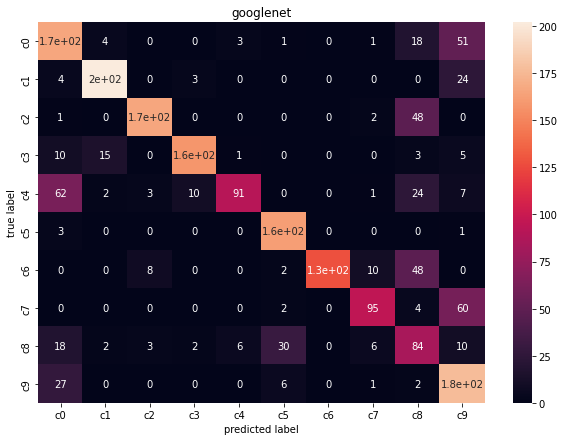

In [ ]:
plot_cm(test_preds,test_labels,'googlenet')

In [ ]:
test_acc, test_preds, test_labels = model_evaluation(mobilenet,test_loader)

In [ ]:
test_acc

0.6046394351991932

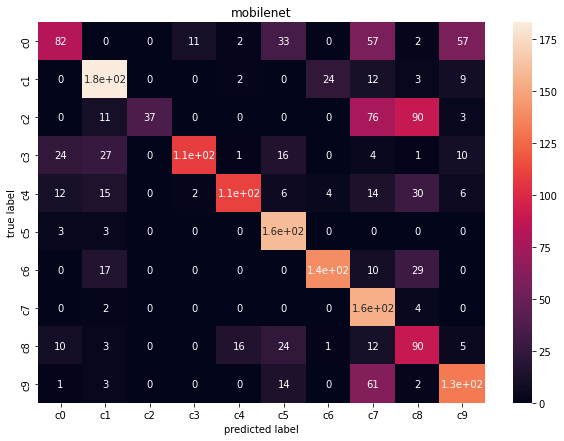

In [ ]:
plot_cm(test_preds,test_labels,'mobilenet')

In [ ]:
test_acc, test_preds, test_labels = model_evaluation(googlenet2,test_loader)

In [ ]:
test_acc

0.6469994957135653

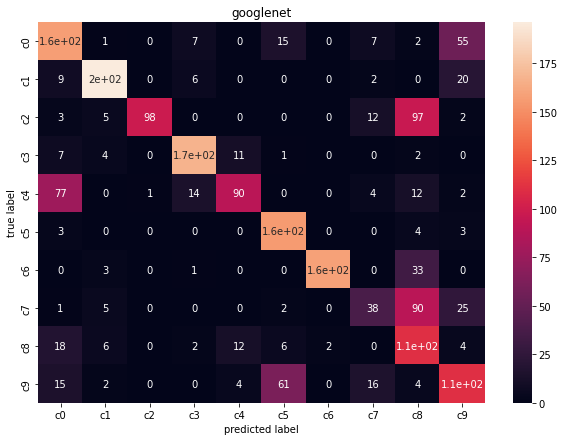

In [ ]:
plot_cm(test_preds,test_labels,'googlenet')

In [ ]:
resnet = resnet()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/aug_models3/"
state = torch.load(save_to + f"{resnet.name}/" +f"model_{resnet.name}_bs_{32}_lr_{0.001}_epoch_{1}")
resnet.load_state_dict(state)

<All keys matched successfully>

In [ ]:
_,_,test_loader = get_loaders(batch_size=8)

In [ ]:
test_acc, test_preds, test_labels = model_evaluation(resnet,test_loader)

In [ ]:
test_acc

0.7165910237014624

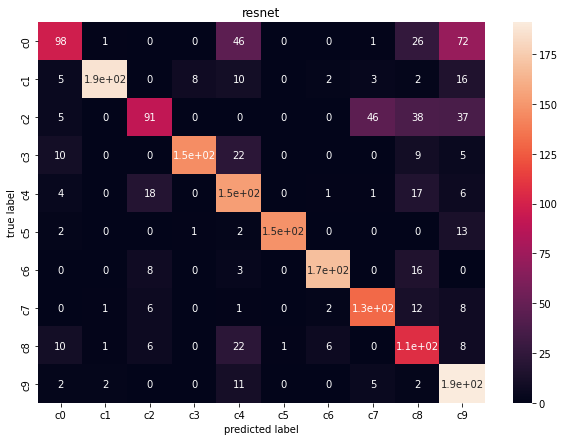

In [ ]:
plot_cm(test_preds,test_labels,'resnet')

# Testing on New Data

We recorded a video to generate this new dataset, and we extracted frames from that and hand-labeled them. The new dataset was organized in the same format as accepted by torchvision's ImageFolder functionality.

Hence, we have this labelled new dataset and the following confusion matrixes.

In [ ]:
from zipfile import ZipFile
with ZipFile('/content/gdrive/MyDrive/MIE1517/1517project/data/New_data_class_584.zip','r') as obj:
  obj.extractall('')

In [ ]:
new_folder = '/content/New_data_class_584'
new_set_aug = torchvision.datasets.ImageFolder(new_folder, transform=transform_val)
new_loader = torch.utils.data.DataLoader(new_set_aug, batch_size=32, shuffle=True)

In [ ]:
def cm_eval(model,loader,title=''):
  test_acc, test_preds, test_labels = model_evaluation(model,loader)
  print(f"accuracy is {test_acc}")
  plot_cm(test_preds,test_labels,title)

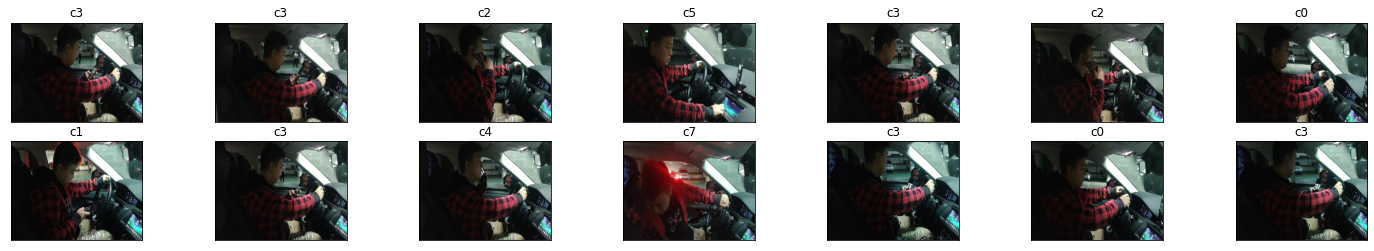

In [ ]:
# obtain one batch of training images
dataiter = iter(new_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
classes = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(14):
    ax = fig.add_subplot(2, 14/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [ ]:
new_loader = torch.utils.data.DataLoader(new_set_aug, batch_size=8, shuffle=True)

This new dataset is evaluated using the different models we have saved so far.

## no augmentation

accuracy is 0.29581151832460734


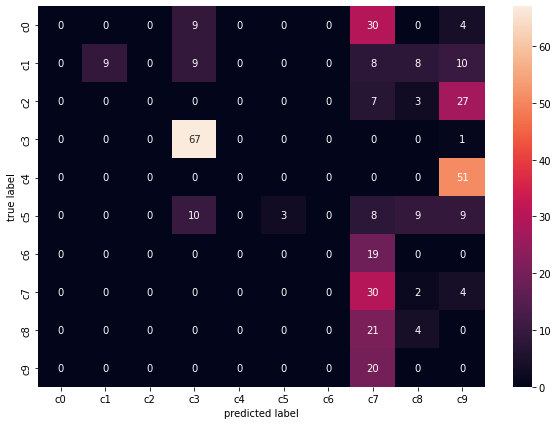

In [ ]:
googlenet = Googlenet()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/normal_models/"
state = torch.load(save_to + f"{googlenet.name}/" +f"model_{googlenet.name}_bs_{16}_lr_{0.001}_epoch_{4}")
googlenet.load_state_dict(state)
cm_eval(googlenet,new_loader)

accuracy is 0.22251308900523561


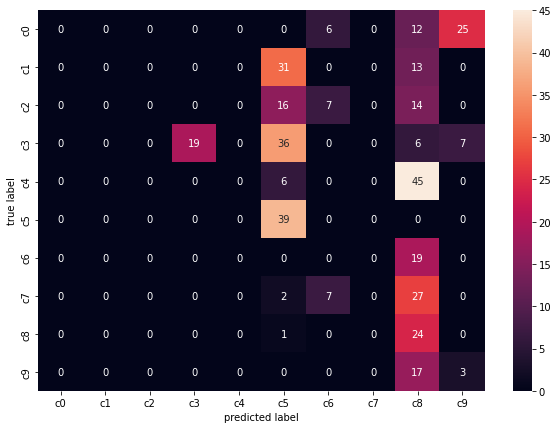

In [ ]:
mobilenet = MobileNet()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/normal_models/"
state = torch.load(save_to + f"{mobilenet.name}/" +f"model_{mobilenet.name}_bs_{16}_lr_{0.001}_epoch_{3}")
mobilenet.load_state_dict(state)
cm_eval(mobilenet,new_loader)

## only imagenet

accuracy is 0.387434554973822


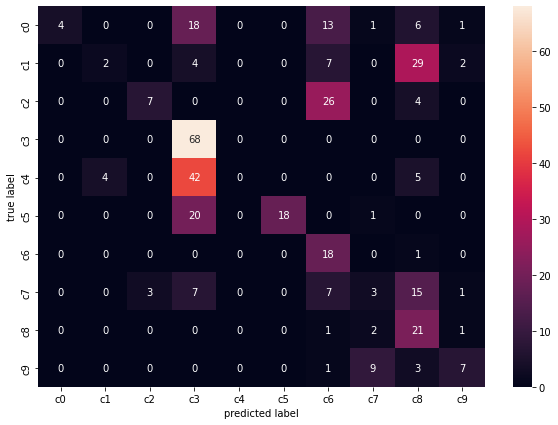

In [ ]:
googlenet = Googlenet()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/aug_models2/"
state = torch.load(save_to + f"{googlenet.name}/" +f"model_{googlenet.name}_bs_{16}_lr_{0.001}_epoch_{2}")
googlenet.load_state_dict(state)
cm_eval(googlenet,new_loader)

accuracy is 0.4712041884816754


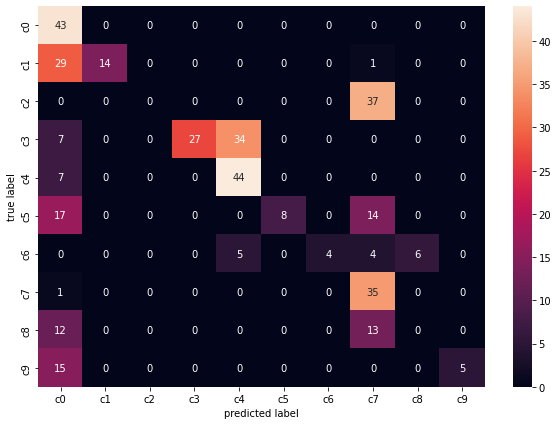

In [ ]:
mobilenet = MobileNet()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/aug_models2/"
state = torch.load(save_to + f"{mobilenet.name}/" +f"model_{mobilenet.name}_bs_{16}_lr_{0.001}_epoch_{0}")
mobilenet.load_state_dict(state)
cm_eval(mobilenet,new_loader)

## imagenet + random perspective

accuracy is 0.3900523560209424


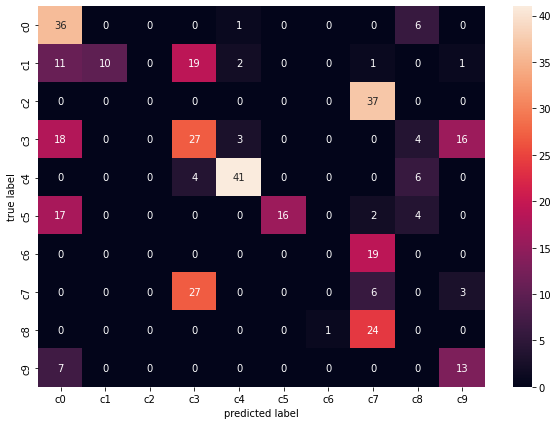

In [ ]:
googlenet = Googlenet()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/aug_models2/"
state = torch.load(save_to + f"{googlenet.name}/" +f"model_{googlenet.name}_bs_{16}_lr_{0.0005}_epoch_{4}")
googlenet.load_state_dict(state)
cm_eval(googlenet,new_loader)

accuracy is 0.13612565445026178


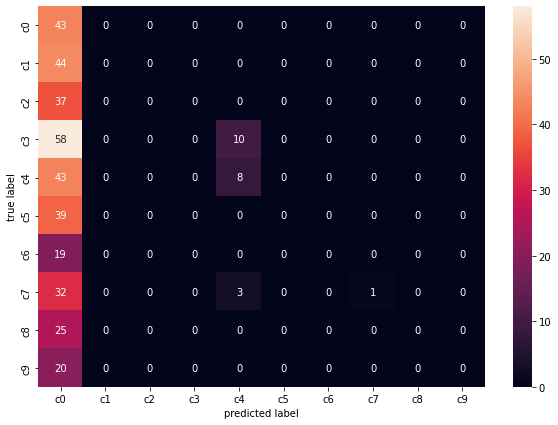

In [ ]:
googlenet2 = Googlenet()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/aug_models2/"
state = torch.load(save_to + f"{googlenet.name}/" +f"model_{googlenet.name}_bs_{32}_lr_{0.001}_epoch_{1}")
googlenet.load_state_dict(state)
cm_eval(googlenet2,new_loader)

accuracy is 0.38481675392670156


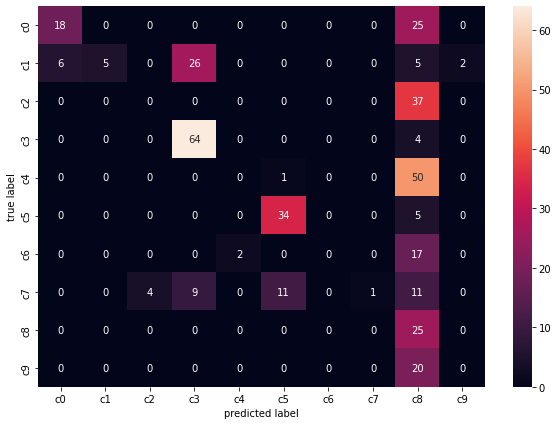

In [ ]:
mobilenet = MobileNet()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/aug_models2/"
state = torch.load(save_to + f"{mobilenet.name}/" +f"model_{mobilenet.name}_bs_{16}_lr_{0.0005}_epoch_{2}")
mobilenet.load_state_dict(state)
cm_eval(mobilenet,new_loader)

## imagenet + random perspective + random erasing

accuracy is 0.27486910994764396


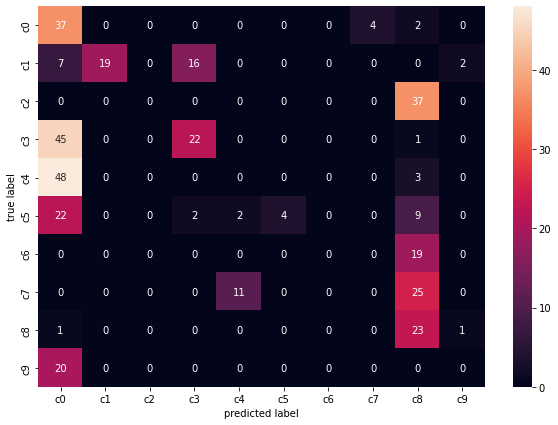

In [ ]:
googlenet = Googlenet()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/aug_models/"
state = torch.load(save_to + f"{googlenet.name}/" +f"model_{googlenet.name}_bs_{16}_lr_{0.0005}_epoch_{3}")
googlenet.load_state_dict(state)
cm_eval(googlenet,new_loader)

accuracy is 0.6099476439790575


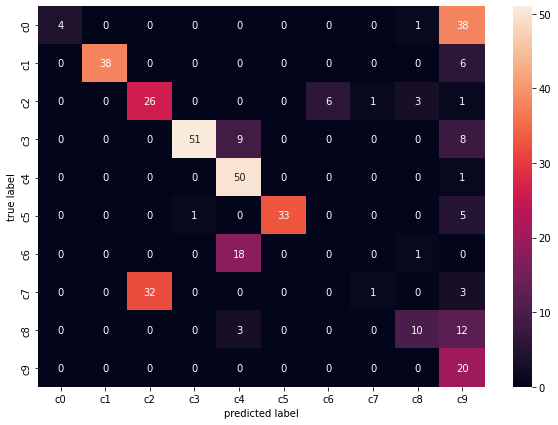

In [ ]:
mobilenet = MobileNet()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/aug_models/"
state = torch.load(save_to + f"{mobilenet.name}/" +f"model_{mobilenet.name}_bs_{16}_lr_{0.0005}_epoch_{5}")
mobilenet.load_state_dict(state)
cm_eval(mobilenet,new_loader)

accuracy is 0.387434554973822


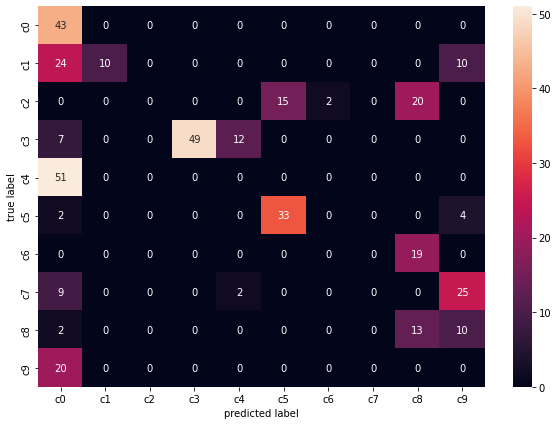

In [ ]:
googlenet2 = Googlenet()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/aug_models/"
state = torch.load(save_to + f"{googlenet2.name}/" +f"model_{googlenet2.name}_bs_{32}_lr_{0.001}_epoch_{5}")
googlenet2.load_state_dict(state)
cm_eval(googlenet2,new_loader)

## larger weight decay(1e-5) + imagenet auto augment + random perspectives

accuracy is 0.4083769633507853


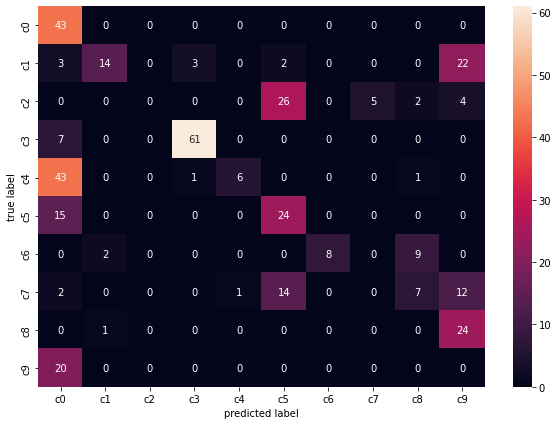

In [ ]:
googlenet = Googlenet()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/aug_models3/"
state = torch.load(save_to + f"{googlenet.name}/" +f"model_{googlenet.name}_bs_{32}_lr_{0.001}_epoch_{7}")
googlenet.load_state_dict(state)
cm_eval(googlenet,new_loader)

accuracy is 0.468586387434555


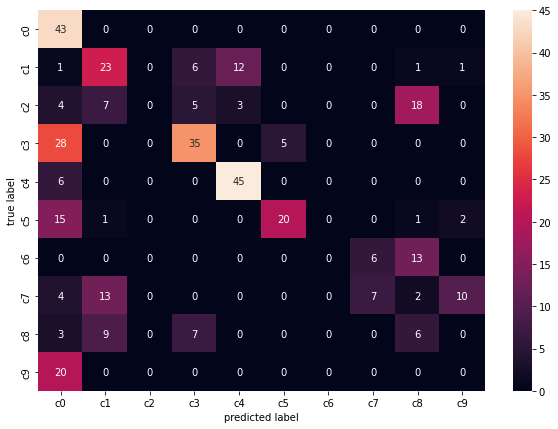

In [ ]:
mobilenet = MobileNet()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/aug_models3/"
state = torch.load(save_to + f"{mobilenet.name}/" +f"model_{mobilenet.name}_bs_{16}_lr_{0.001}_epoch_{3}")
mobilenet.load_state_dict(state)
cm_eval(mobilenet,new_loader)

accuracy is 0.5261780104712042


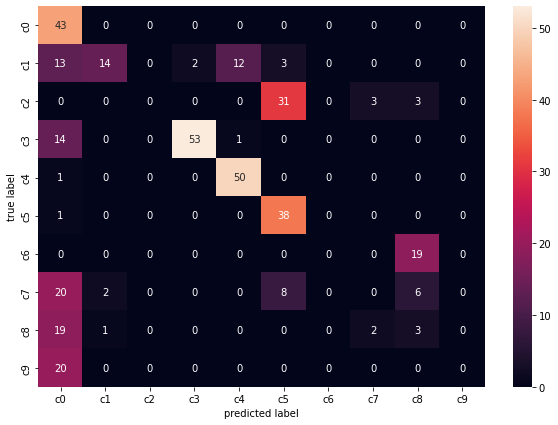

In [ ]:
googlenet2 = Googlenet()
save_to = "/content/gdrive/MyDrive/MIE1517/1517project/aug_models3/"
state = torch.load(save_to + f"{googlenet.name}/" +f"model_{googlenet.name}_bs_{32}_lr_{0.001}_epoch_{5}")
googlenet2.load_state_dict(state)
cm_eval(googlenet2,new_loader)

In this section, we ran the best models (GoogleNet, MobileNet and GoogleNet2) on our new collected dataset. To test its results on different augmentation techniques, we use those models trained on dataset with different aug techniques. We found that most of these reach at relatively low accuracy, and the MobileNet trained with AutoAugmentation + Random Perspective + Random Erasing earns the highest at the new data with 0.6 accuracy.

As we can see from the predictions on new data, our models gradually obtain the ability to generalize from the training set. The result goes from 30% accuracy to 60% accuracy by doing data augmentations, apply dropout layers and weight decays. The early stopping points are also crucial for us to obtain the best models.

# Video Demonstration

Below is the code we used to set up the Video Demonstration we presented. The code goes through a video, extracts frames, makes predictions, annotates them and returns the annotated video.

In [ ]:
import os
import cv2
import imutils
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
def get_imgs_from_video(video_in   = '/content/driving_1123_1.mp4',
                        image_out  = '/content/Demo_Video1121/',
                        frame_skip = 5):
    """
    capture 1 image every 5 frames in video and save to folders
    """

    cap = cv2.VideoCapture(video_in)
    frame_cnt = 0

    if os.path.exists(image_out) == 0:
      os.makedirs('/content/Demo_Video1121/')
    print("capturing frames from the video...")

    while cap.isOpened():
        ret, frame = cap.read()
        if ret == 0: break
        # count total frames
        frame_cnt += 1
        if frame_cnt % frame_skip == 1:
            frame = imutils.resize(frame, height = 480)
            # should be 640 * 480
            # actual size (480, 853, 3)
            pic_cnt = int(np.ceil(frame_cnt/frame_skip))
            cv2.imwrite(image_out + str(pic_cnt) + '.jpg', frame)

    print("totally %d frames, %d images captured." % (frame_cnt, pic_cnt))

    cap.release()
    cv2.destroyAllWindows()

In [ ]:
def load_images_squeeze(img_path = '/content/Demo_Video1121/'):
  """
  read all images into img_array
  """
  # count files
  files = os.listdir(img_path)
  img_cnt = len(files)

  img_array = np.zeros([img_cnt, 480, 853, 3])
  img_array_origin = []

  print("loading and resizing images from folder...")
  for i in range(img_cnt):
    filename = img_path + str(i+1) + '.jpg'
    frame = plt.imread(filename)
    img_array[i] = frame/255
    frame = cv2.imread(filename)
    img_array_origin.append(frame)

  # resize and transpose
  # from 853 to 640 -> 120: 760
  # img_array = img_array[:,:,120:760,:]
  img_array = np.transpose(img_array,(0,3,1,2))
  img_array = np.array(img_array, dtype = float)

  return img_array, img_array_origin

In [ ]:
def model_prediction_and_prob_squeeze(model, img_array):
  """
  generate prediction and probability list
  """
  # use for loop since the above will broke...(ram full)
  imgs = np.zeros([img_array.shape[0], 3, 480, 640])
  #img_transform = transforms.Resize([480, 640])
  img_transform = transforms.Compose([transforms.Resize([480, 640])])

  print("transforming data...")

  for i in range(len(img_array)):
    img_tensor = torch.tensor(img_array[i])
    img_tensor = img_transform(img_tensor)
    imgs[i] = img_tensor

  # dataloader
  loader = DataLoader(torch.tensor(imgs).float(), batch_size = 8, shuffle = False)

  pred_list = []
  prob_list = []

  # make predictions on new data and store results
  model.to(device)
  softmax_f = nn.Softmax()
  print("calculating probability and prediction...")
  for imgs in loader:
    imgs = imgs.to(device)
    out  = model(imgs)
    # prediction
    pred = torch.max(out, 1)[1]
    pred = list(pred.detach().cpu().numpy())
    # probability
    prob = softmax_f(out).max(axis = 1)[0]
    prob = list(prob.detach().cpu().numpy())

    pred_list += pred
    prob_list += prob

  return pred_list, prob_list

In [ ]:
def conver_img_to_video(img_array_origin, pred_list, prob_list):
  """
  add caption and make videos with images
  """

  # class info
  class_index = ['c' + str(i) for i in range(10)]
  class_name  = ['safe driving', 'texting right', 'phone talking right', 'texting left',
                'phone talking left', 'operating the radio', 'drinking', 'reaching behind',
                'hair and makeup', 'talking to passenger']

  # font and VideoWriter setting
  font = cv2.FONT_HERSHEY_SIMPLEX
  fourcc = cv2.VideoWriter_fourcc(*"mp4v")
  out = cv2.VideoWriter('demo_video.mp4',
                        fourcc,
                        fps = 10,
                        frameSize = (853,480)) # should be changed

  classes = np.array(class_name)
  prediction = np.array(pred_list, dtype='int64')
  frame_text = classes[prediction]

  # add caption and make video
  print("adding caption and converting video...")
  for i in range(len(img_array_origin)):
    caption = frame_text[i] + ": %.2f%%" % (prob_list[i] * 100)
    img_with_caption = img_array_origin[i].copy()
    cv2.putText(img_with_caption,
                caption,
                org = (50,50),
                fontFace = font,
                fontScale = 0.8,
                color = (0,255,255),
                thickness = 2,
                lineType = cv2.LINE_4)
    out.write(img_with_caption)

  out.release()
  print("video has been saved, ready to download.")

In [ ]:
# load the best model with data augmentation
mobilenet = MobileNet()
save_to = "/content/"
state = torch.load(save_to + f"model_{mobilenet.name}_bs_{16}_lr_{0.0005}_epoch_{5}")
mobilenet.load_state_dict(state)

mobilenet.eval()
mobilenet.to(device)

In [ ]:
# get frames from video
get_imgs_from_video()
# load images array
img_array, img_array_origin = load_images_squeeze()
# get prediction and probability for each frame
pred_list, prob_list = model_prediction_and_prob_squeeze(mobilenet, img_array)
# make demo video
conver_img_to_video(img_array_origin, pred_list, prob_list)

# Final Results

| Model Name | Augmentation technique | Train Accuracy | Validation Accuracy | Test Accuracy | New data Accuracy|
| ------------- | ------------- | ------------- | ------------- | ------------- | ------------- |  
| Googlenet | No Augmentation | 0.9821| 0.8524 | 0.6908 | 0.2958  |
| Googlenet | Imagenet | 0.9522| 0.8243 | 0.7771 | 0.3874  |
| Googlenet | Imagenet + Random perspectives + Random erasing | 0.8962 | 0.8201| 0.7599 | 0.3874  |
| Googlenet | Imagenet + Random perspectives  | 0.9653 | 0.8325| 0.7136 | 0.3900  |
| Googlenet | Larger weight decay(1e-5)+Imagenet + Random perspectives  | 0.8953 | 0.8212| 0.7206| 0.5261  |
| VGG |No Augmentation | 0.9983| 0.7202 | -- | -- |
| VGG |Imagenet | 0.9930| 0.6173 | -- | -- |
| Alexnet |No Augmentation| 0.9857 | 0.5422 | -- | -- |
| Alexnet |Imagenet| 0.1083 | 0.1112 | -- | -- |
| Resnet |No Augmentation | 0.9695 | 0.6887 | -- | -- |
| Resnet |Imagenet | 0.9779 | 0.7687 | -- | -- |
| Resnet | Imagenet + Random perspectives + Random erasing  |0.7221| 0.7559 | -- | -- |
| Resnet | Larger weight decay(1e-5)+Imagenet + Random perspectives  |0.7775| 0.7912 | 0.7165 | -- |
| MobileNet | No Augmentation| 0.9753 |0.8412| 0.7554 | 0.2225 |
| MobileNet | Imagenet | 0.8485 |0.8265| 0.7786 | 0.4712 |
| MobileNet |  Imagenet + Random perspectives + Random erasing  | 0.9548 |0.8411| 0.7236 | 0.6099 |
| MobileNet |  Imagenet + Random perspectives  | 0.9596 | 0.8099| 0.6974 | 0.3848 |
| MobileNet |  Larger weight decay(1e-5)+Imagenet + Random perspectives   | 0.8500 | 0.7477| 0.6046 | 0.4685 |


# Conclusion

Over the course of this project, we have successfully implemented a Distracted Driver Detection system, using a lightweight modelling architecture and verified that it works on newly produced data. Our methodology heavily leverages transfer learning and sophisticated data augmentation techniques.

## Our Journey

At the beginning, we encountered overfitting problems as we tried different transfer models. To deal with this, we mainly use different data augmentation tools, including AutoAugmentation, Random Perspective, Random Erasing and their combinitions. Besides this, we also tried different batch sizes, learning rates, weight decays and dropout layers. We note that the tuning procedures followed are not faithfully represented in our preceding code, as we had cut out/modified much of our tuning as the project progressed.

We found different models have their advantage at predicting some classes. Hence, we think it would be better to combine the output and generate single a probability using ensemble models. But due to cuda memory issues, we are not able to deploy the ensemble model to see the result.

## Performance on New Data

After dealing with overfitting, we asked our friend to record a video in which he performs 10 types of actions: c0-c9 in our model. We found that our best model could only predict that with 60% accuracy. However, there are truly some reasons to be noted for future reference which made it very hard for the model to predict.

*   The image quality needs to be improved.
*   The environment was dark and fuzzy.
*   There are other people and cars passing through in the background.
*   Shining lights were sometimes so prominent as to obscure the driver.
*   The angle of video capture differed from those in the training dataset.

But in practice, it can be hard to achieve these idealized conditions.

We note that the accuracy of prediction is largely influenced by the angle from which is images are taken. The new data images we obtained are actually taken from a smart phone of different angle. In this case, we have to rely heavily on our models' generalization ability. If the same dashboard camera is used and set at a similar location as in the train/val/test set(dashboard camera needs to be fixed), then we believe we can actually get a prediction accuracy close to 80% as the result shown for the test set.

## Ideas for Future Works

We hope our project and experiences can give some insights on the directions in which this research can be taken further. Here are some ideas that were bounced around but were not attempted by us (mainly due to lack of time and computation):


1.   **Ensemble Models**: As stated earlier, we can potentially combine the strengths of the different architectures we attempted and produce better results.
2.   **Pose Data** (of the seated driver): It could be a better indicator of the actions being performed. To this extent, we investigated the API offered by the mediapipe library, and feel that extracted pose data can supplement our models' performance.
3.   **Face & Background Swaps**: The dataset images were taken in a controlled environment by trained professionals on behalf of State Farm Insurance, and naturally represent quite a small subset of the ethnicities of drivers and types of environments. Using modern AI-based face-swapping technologies or background-removal technologies, we can augment our datasets with a more diverse distribution of data, which better represent real-life scenarios.

